This notebook best viewed here: https://nbviewer.jupyter.org

This notebook is for the interior variety of Douglas fir GEA mapping pops

- First I LD-prune SNPs to use for structure correction in baypass.
- Then I use LD-pruned SNPs to estimate the covariance matrix across 5 independent runs of the core mode of baypass, and to ensure convergence I calculate the pairwise correlation of the matrices across runs (I found that these runs were highly correlated, r2 > 0.998).
- Then I run baypass in STD mode (mcmc) for SNPs in our data.

In [1]:
from pythonimports import *

DIR = '/data/projects/pool_seq/DF_datasets'
snpdir = op.join(DIR, 'DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC')
assert op.exists(snpdir)
baydir = makedir(op.join(snpdir, 'baypass'))
op.exists(baydir)

True

# Choose SNPs for GEA structure correction in baypass

First choose loci for each variety (coastal and interior) then choose loci across both.

for SNPs with MAF > 0.05 and for all pops: 40 < DP < 1000, randomly choose one snp per contig (for contigs > 1Kbp), then LD prune so no pairwise r2 > 99.9th percentile of r2

#### get the snps

In [3]:
lview,dview = get_client()

56 56


In [4]:
def get_mafdict(afs, roundto):
    # bins for p52 depth
    mafs = [round(1-float(af),roundto) if float(af) > 0.5 else round(float(af),roundto) for af in afs]
    t = table(mafs)
    mafsdict = OrderedDict()
    for k in sorted(t):
        newk = '%.10f' % k
        if not newk in mafsdict:
            mafsdict[newk] = t[k]
        else:
            mafsdict[newk] += t[k]
    retdict = OrderedDict()
    for newk,count in mafsdict.items():
        retdict[newk] = count / sum(mafsdict.values())
    print(len(retdict.keys()))

    return retdict

def subcategorybar(X, vals, width=.9):
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge")   
    plt.xticks(_X, X)

def make_mafdict_fig(pruned_snpdict, all_snpdict, title=None):
    fig = plt.figure(figsize=(25,5))
    X = ['%.3f' % float(key) for key in sorted(keys(pruned_snpdict))]
    Y = [pruned_snpdict[freq] for freq in sorted(keys(pruned_snpdict))]
    Z = [all_snpdict[freq] for freq in sorted(keys(all_snpdict))]
    subcategorybar(X, [Y,Z])
    plt.legend(['filtered snps', 'all snps'],fontsize=20)
    plt.ylabel('proportion of SNPs in category',size=20)
    plt.xlabel('minor allele frequency',size=20)
    plt.title(title, size=20)
    plt.show()

def get_skipto_df(f, skipto, nrows, cols=None, filter_maf=False, **kwargs):
    """Retrieve dataframe in parallel so that all rows are captured when iterating.
    
    f = filename to open
    skipto = row number to skip, read rows thereafter
    nrows = how many rows to read from f after skipto
    """
    import pandas
    
    if skipto == 0:
        df = pandas.read_table(f, nrows=nrows-1)
    else:
        df = pandas.read_table(f, skiprows=range(1, skipto), nrows=nrows)
    
    if cols is not None:
        if isinstance(cols, str):
            cols = [cols]
        df = df[cols].copy()
    
    if filter_maf is True:
        return maf_filter(df, **kwargs)
    
    return df
dview['get_skipto_df'] = get_skipto_df

def filter_depth(*args):
    """Filter min/max depth, reduce columns."""
    chunk = get_skipto_df(*args)
    dpcols = [col for col in chunk.columns if '.DP' in col]
    freqcols = [col for col in chunk.columns if '.FREQ' in col]
    cols = ['CHROM', 'locus', 'AF', 'MAF'] + dpcols + freqcols
    chunk = chunk[cols].copy()
    for col in dpcols:
        chunk = chunk[chunk[col] >= 20].copy()
        chunk = chunk[chunk[col] < 1000].copy()
    chunk.index = chunk['locus'].tolist()
    return chunk

In [5]:
snpdir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC'

In [6]:
# get linenums for each variety and each type
linenums = {}
for f in fs(snpdir, pattern='SNP', dirs=False):
    out = !wc -l $f
    linenums[f] = int(out[0].split()[0])-1
    print(op.basename(f), linenums[f])

DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated.txt 2350673


In [7]:
# filter for depth in parallel as I read it in
f = keys(linenums)[0]
nrows = 50000
jobs = []
for skipto in range(0, linenums[f], nrows):
    jobs.append(lview.apply_async(filter_depth, *(f, skipto, nrows)))
watch_async(jobs)

48
48


In [8]:
# combine depth-filtered chunks into one df
snps = pd.concat([j.r for j in jobs])
print(snps.shape)
snps.head()

(821310, 94)


,CHROM,locus,AF,MAF,DF_p1.DP,DF_p2.DP,DF_p23.DP,DF_p24.DP,DF_p25.DP,DF_p26.DP,DF_p27.DP,DF_p28.DP,DF_p10.DP,DF_p29.DP,DF_p30.DP,DF_p31.DP,DF_p32.DP,DF_p11.DP,DF_p12.DP,DF_p50.DP,DF_p51.DP,DF_p52.DP,DF_p53.DP,DF_p13.DP,DF_p72.DP,DF_p14.DP,DF_p73.DP,DF_p74.DP,DF_p75.DP,DF_p76.DP,DF_p77.DP,DF_p78.DP,DF_p79.DP,DF_p80.DP,DF_p81.DP,DF_p15.DP,DF_p82.DP,DF_p83.DP,DF_p84.DP,DF_p90.DP,DF_p16.DP,DF_p91.DP,DF_p92.DP,DF_p93.DP,DF_p95.DP,DF_p96.DP,DF_p97.DP,DF_p98.DP,DF_p17.DP,DF_p1.FREQ,DF_p2.FREQ,DF_p23.FREQ,DF_p24.FREQ,DF_p25.FREQ,DF_p26.FREQ,DF_p27.FREQ,DF_p28.FREQ,DF_p10.FREQ,DF_p29.FREQ,DF_p30.FREQ,DF_p31.FREQ,DF_p32.FREQ,DF_p11.FREQ,DF_p12.FREQ,DF_p50.FREQ,DF_p51.FREQ,DF_p52.FREQ,DF_p53.FREQ,DF_p13.FREQ,DF_p72.FREQ,DF_p14.FREQ,DF_p73.FREQ,DF_p74.FREQ,DF_p75.FREQ,DF_p76.FREQ,DF_p77.FREQ,DF_p78.FREQ,DF_p79.FREQ,DF_p80.FREQ,DF_p81.FREQ,DF_p15.FREQ,DF_p82.FREQ,DF_p83.FREQ,DF_p84.FREQ,DF_p90.FREQ,DF_p16.FREQ,DF_p91.FREQ,DF_p92.FREQ,DF_p93.FREQ,DF_p95.FREQ,DF_p96.FREQ,DF_p97.FREQ,DF_p98.FREQ,DF_p17.FREQ
jcf7190000000004-54508,jcf7190000000004,jcf7190000000004-54508,0.080056,0.080056,65.0,32.0,44.0,65.0,67.0,51.0,52.0,37.0,51.0,70.0,56.0,45.0,49.0,61.0,66.0,58.0,54.0,65.0,50.0,57.0,76.0,49.0,54.0,33.0,65.0,67.0,68.0,69.0,56.0,75.0,58.0,42.0,71.0,71.0,27.0,53.0,67.0,72.0,63.0,67.0,82.0,68.0,52.0,59.0,28.0,4.62%,6.25%,15.91%,10.77%,NaN,0%,5.77%,5.41%,NaN,NaN,7.14%,2.22%,6.12%,4.92%,0%,17.24%,20.37%,0%,0%,1.75%,NaN,28.57%,20.37%,3.03%,15.38%,2.99%,2.94%,NaN,7.14%,2.67%,20.69%,7.14%,NaN,5.63%,3.7%,NaN,4.48%,NaN,4.76%,5.97%,NaN,0%,13.46%,18.64%,10.71%
jcf7190000000004-54540,jcf7190000000004,jcf7190000000004-54540,0.333741,0.333741,67.0,36.0,47.0,67.0,70.0,55.0,56.0,38.0,56.0,70.0,58.0,44.0,47.0,63.0,69.0,50.0,50.0,68.0,54.0,52.0,73.0,57.0,67.0,40.0,69.0,68.0,72.0,76.0,62.0,76.0,54.0,50.0,76.0,77.0,34.0,53.0,67.0,69.0,65.0,67.0,82.0,69.0,58.0,62.0,26.0,25.37%,30.56%,NaN,35.82%,35.71%,43.64%,32.14%,23.68%,30.36%,30%,36.21%,52.27%,21.28%,34.92%,27.54%,30%,20%,48.53%,57.41%,32.69%,27.4%,29.82%,23.88%,40%,53.62%,32.35%,44.44%,34.21%,40.32%,23.68%,29.63%,30%,27.63%,44.16%,NaN,5.66%,32.84%,46.38%,46.15%,29.85%,21.95%,20.29%,27.59%,40.32%,NaN
jcf7190000000004-54587,jcf7190000000004,jcf7190000000004-54587,0.111745,0.111745,76.0,31.0,48.0,72.0,65.0,52.0,67.0,41.0,62.0,78.0,55.0,41.0,61.0,58.0,75.0,52.0,57.0,69.0,62.0,59.0,69.0,64.0,58.0,47.0,57.0,67.0,81.0,78.0,67.0,79.0,58.0,52.0,77.0,87.0,39.0,51.0,67.0,70.0,66.0,60.0,83.0,69.0,64.0,72.0,22.0,1.32%,9.68%,20.83%,9.72%,6.15%,5.77%,4.48%,4.88%,NaN,14.1%,5.45%,0%,4.92%,1.72%,0%,15.38%,42.11%,37.68%,NaN,NaN,10.14%,21.88%,20.69%,8.51%,22.81%,5.97%,13.58%,8.97%,2.99%,NaN,18.97%,1.92%,10.39%,10.34%,NaN,NaN,5.97%,12.86%,4.55%,6.67%,NaN,0%,26.56%,15.28%,NaN
jcf7190000000004-54589,jcf7190000000004,jcf7190000000004-54589,0.802416,0.197584,75.0,31.0,46.0,74.0,67.0,50.0,67.0,41.0,60.0,78.0,55.0,41.0,60.0,57.0,73.0,51.0,56.0,69.0,63.0,59.0,71.0,63.0,59.0,44.0,58.0,67.0,79.0,77.0,65.0,78.0,58.0,54.0,74.0,87.0,39.0,51.0,67.0,70.0,65.0,60.0,84.0,68.0,64.0,73.0,22.0,86.67%,83.87%,89.13%,84.93%,83.58%,84%,58.21%,85.37%,71.67%,93.59%,80%,80.49%,78.33%,85.96%,100%,84.31%,89.29%,89.86%,61.9%,77.97%,63.38%,76.19%,72.88%,86.36%,91.38%,65.67%,93.67%,80.52%,72.31%,74.36%,79.31%,72.22%,79.73%,81.61%,58.97%,68.63%,76.12%,84.29%,95.38%,83.33%,76.19%,61.76%,82.81%,97.26%,86.36%
jcf7190000000004-54643,jcf7190000000004,jcf7190000000004-54643,0.187744,0.187744,68.0,34.0,49.0,53.0,76.0,61.0,72.0,56.0,61.0,66.0,62.0,47.0,64.0,55.0,68.0,47.0,50.0,49.0,65.0,76.0,75.0,70.0,59.0,45.0,65.0,65.0,72.0,80.0,57.0,76.0,66.0,68.0,77.0,86.0,41.0,49.0,74.0,66.0,57.0,53.0,87.0,64.0,68.0,70.0,21.0,14.71%,NaN,2.04%,22.64%,28.95%,34.43%,12.5%,12.5%,11.48%,18.18%,11.29%,31.91%,6.25%,21.82%,0%,23.4%,8%,28.57%,18.46%,21.05%,25.33%,15.71%,13.56%,37.78%,1.54%,18.46%,22.22%,30%,21.05%,NaN,12.12%,19.12%,19.48%,27.91%,9.76%,NaN,20.27%,28.79%,26.32%,13.21%,14.94%,12.5%,22.06%,30%,NaN


In [14]:
luni(snps['CHROM'])

26304

#### reduce those snps on contigs > 1Kbp

In [15]:
# get contig lengths
lengths = pd.read_table('/data/database/DouglasFir_ref_genome/DF_ref_edit.fasta.length', header=None)
lengths.head()

,0,1
0,jcf7190000000000,104664
1,jcf7190000000004,713351
2,jcf7190000000008,780568
3,jcf7190000000009,80234
4,jcf7190000000010,335878


In [16]:
# get a dict of contigs and there length if length > 1000
lens = dict((contig,length) for (contig,length) in zip(lengths[0],lengths[1]) if length>1000)
len(lens.keys())

79910

In [17]:
# reduce reduced columns to only those that matter
freqcols = [col for col in snps.columns if '.FREQ' in col]
reduced = snps[snps['CHROM'].isin(list(lens.keys()))].copy()
reduced = reduced.loc[:, freqcols + ['CHROM', 'AF', 'MAF']]
reduced.shape, snps.shape

((819096, 48), (821310, 94))

In [18]:
len(freqcols)

45

In [19]:
min(lens.values())

1001

46
46


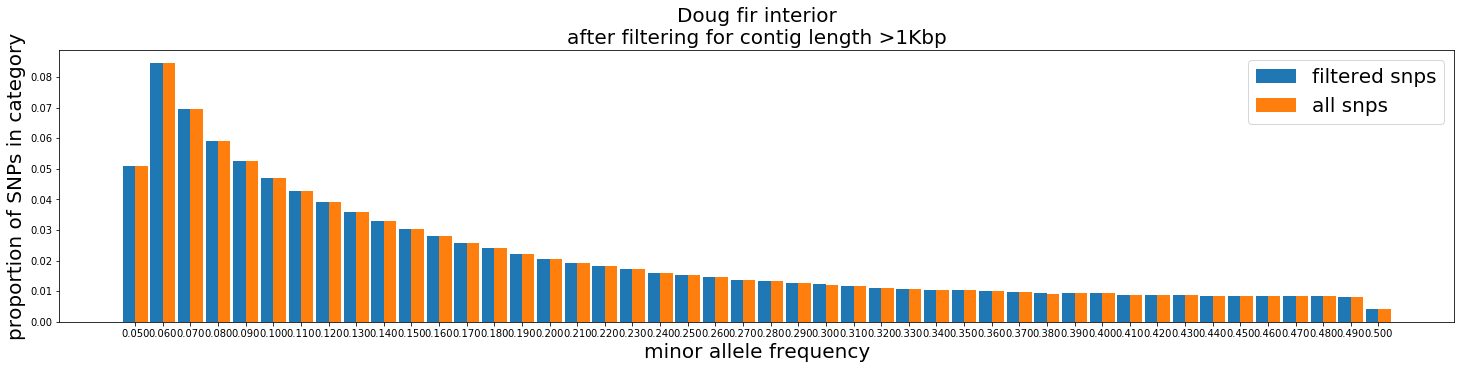

In [20]:
# compare MAF spectrum between depth-filtered and precursor
make_mafdict_fig(get_mafdict(reduced['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir interior\nafter filtering for contig length >1Kbp')

#### reduce to no missing data 

Turns out I can't filter for no missing data, the MAF spectrum doesn't match well with MAF spectrum of all data. Filter instead for % missing below.

In [21]:
# def reduce_col(col):
#     """Return list of loci with no missing data for pop.FREQ col."""
#     return reduced[~reduced[col].isnull()].index

In [22]:
# # get loci from each pop without missing data
# reduce_col_outs = []
# for col in nb(freqcols):
#     reduce_col_outs.append(reduce_col(col))

100%|██████████| 45/45 [00:28<00:00,  1.60it/s]


In [23]:
# # combine returns to get loci with no missing data across pop.FREQ cols
# nomissingloci = snps.index.tolist()
# for out in nb(reduce_col_outs):
#     nomissingloci = list(set(nomissingloci).intersection(out))
# len(nomissingloci), luni(nomissingloci)

100%|██████████| 45/45 [00:09<00:00,  4.55it/s]


(251586, 251586)

In [24]:
# # reduce snp table to no missing loci
# reduced_nm = reduced[reduced.index.isin(nomissingloci)]
# reduced_nm.head()

,DF_p1.FREQ,DF_p2.FREQ,DF_p23.FREQ,DF_p24.FREQ,DF_p25.FREQ,DF_p26.FREQ,DF_p27.FREQ,DF_p28.FREQ,DF_p10.FREQ,DF_p29.FREQ,DF_p30.FREQ,DF_p31.FREQ,DF_p32.FREQ,DF_p11.FREQ,DF_p12.FREQ,DF_p50.FREQ,DF_p51.FREQ,DF_p52.FREQ,DF_p53.FREQ,DF_p13.FREQ,DF_p72.FREQ,DF_p14.FREQ,DF_p73.FREQ,DF_p74.FREQ,DF_p75.FREQ,DF_p76.FREQ,DF_p77.FREQ,DF_p78.FREQ,DF_p79.FREQ,DF_p80.FREQ,DF_p81.FREQ,DF_p15.FREQ,DF_p82.FREQ,DF_p83.FREQ,DF_p84.FREQ,DF_p90.FREQ,DF_p16.FREQ,DF_p91.FREQ,DF_p92.FREQ,DF_p93.FREQ,DF_p95.FREQ,DF_p96.FREQ,DF_p97.FREQ,DF_p98.FREQ,DF_p17.FREQ,CHROM,AF,MAF
jcf7190000000004-54589,86.67%,83.87%,89.13%,84.93%,83.58%,84%,58.21%,85.37%,71.67%,93.59%,80%,80.49%,78.33%,85.96%,100%,84.31%,89.29%,89.86%,61.9%,77.97%,63.38%,76.19%,72.88%,86.36%,91.38%,65.67%,93.67%,80.52%,72.31%,74.36%,79.31%,72.22%,79.73%,81.61%,58.97%,68.63%,76.12%,84.29%,95.38%,83.33%,76.19%,61.76%,82.81%,97.26%,86.36%,jcf7190000000004,0.802416,0.197584
jcf7190000000004-55528,37.08%,35%,39.68%,34.34%,35.82%,34.55%,45.45%,40.32%,34.18%,43.66%,39.33%,60.42%,46.94%,45.88%,42.55%,30.38%,31.82%,63.51%,48.19%,32.93%,45.35%,41.67%,44.29%,34.09%,58.24%,32.18%,35%,44.68%,46.59%,23.15%,21.18%,40.35%,43.86%,54.9%,25.53%,27.91%,33.33%,35.05%,49.32%,41.25%,36.89%,29.03%,31.82%,38.18%,15.38%,jcf7190000000004,0.389853,0.389853
jcf7190000000004-57381,27.27%,44%,50%,31.15%,56.25%,36.73%,35.42%,42%,39.22%,34.78%,26.15%,65.52%,53.19%,32.14%,49.09%,25.58%,35.56%,68.89%,48.15%,43.86%,55.38%,34.92%,53.19%,50%,56.06%,23.44%,41.67%,53.52%,37.68%,39.71%,29.69%,53.19%,49.23%,57.69%,25%,27.5%,37.5%,45%,57.58%,46.51%,31.94%,44.83%,31.88%,39.53%,29.17%,jcf7190000000004,0.421756,0.421756
jcf7190000000004-289709,32.79%,42.86%,16.67%,31.85%,27.96%,33.33%,18.48%,20.83%,31.76%,21.98%,11.57%,20%,38.67%,27.72%,30.33%,31.08%,20.9%,2.38%,10.16%,15.52%,28.24%,18%,11.46%,26.67%,12.12%,10.53%,19.88%,25.17%,35.54%,20.13%,20.41%,29.59%,19.67%,39.5%,17.5%,24.14%,27.78%,21%,13.04%,23.08%,25.55%,28.42%,11.46%,15.38%,30%,jcf7190000000004,0.231417,0.231417
jcf7190000000004-289915,64.17%,60.87%,52.94%,62.86%,59.14%,68.75%,45.88%,53.49%,54.1%,56.72%,45.45%,39.13%,60.34%,68.69%,90.1%,54.69%,45.1%,13.16%,22.76%,41.58%,33.33%,39.02%,22.08%,56.86%,28.28%,40.95%,42.96%,44.07%,39.58%,45.32%,63.06%,40.85%,44.55%,60.19%,47.22%,57.14%,54.63%,52.04%,48.57%,51.85%,37.5%,58.51%,42.42%,68.42%,54.29%,jcf7190000000004,0.496315,0.496315


46
46


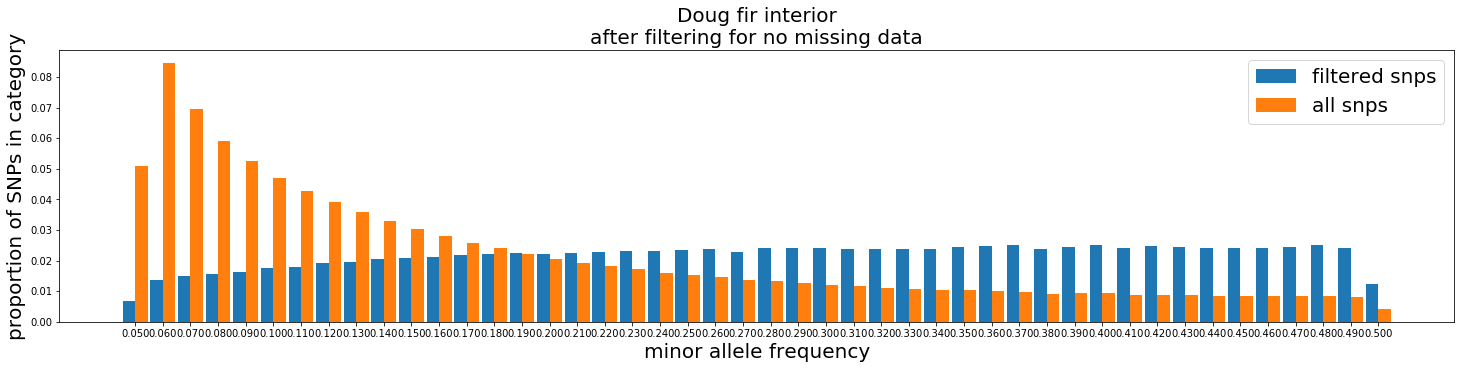

In [25]:
# # compare MAF spectrum between no-missing and precursor
# make_mafdict_fig(get_mafdict(reduced_nm['AF'], roundto=2),
#                  get_mafdict(snps['AF'], roundto=2),
#                  title='Doug fir interior\nafter filtering for no missing data')

#### try to reduce to X% missing data ... 

Result: any filtering resulted in a visibly different MAF spectrum

In [26]:
def filter_perc(df, perc=0.10):
    """Filter df for missing data below perc."""
    import pandas
    from tqdm.notebook import tqdm as tnb
    
    freqcols = [col for col in df.columns if '.FREQ' in col]
    keep = []
    for locus in tnb(df.index):
        if sum(df.loc[locus,:].isnull())/len(freqcols) <= perc:
            keep.append(locus)
    return keep

In [31]:
jobs = []
tosend = []
i = 0
for locus in tnb(reduced.index):
    tosend.append(locus)
    if len(tosend) == 21732 or (i+1)==nrow(reduced):
        jobs.append(lview.apply_async(filter_perc, reduced.loc[tosend, :]))
#         jobs.append(lview.apply_async(filter_perc, reduced.loc[tosend, :], **{'perc':0.2}))
        tosend = []
    i += 1
watch_async(jobs)

38
38


In [32]:
perc_loci = []
for j in jobs:
    perc_loci.extend(j.r)
len(perc_loci)

513895

46
46


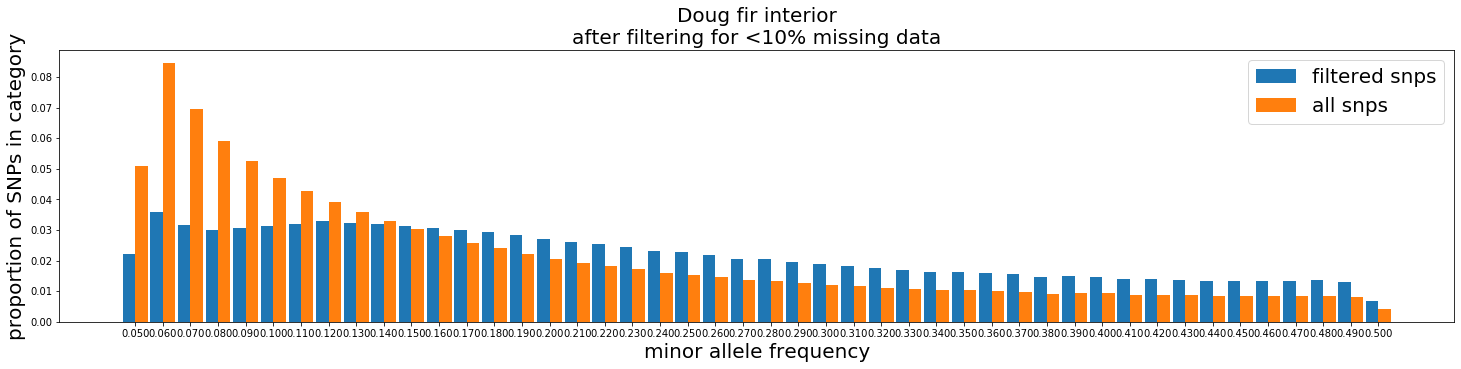

In [33]:
# compare MAF spectrum between no-missing and precursor
make_mafdict_fig(get_mafdict(reduced.loc[perc_loci, 'AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir interior\nafter filtering for <10% missing data')

46
46


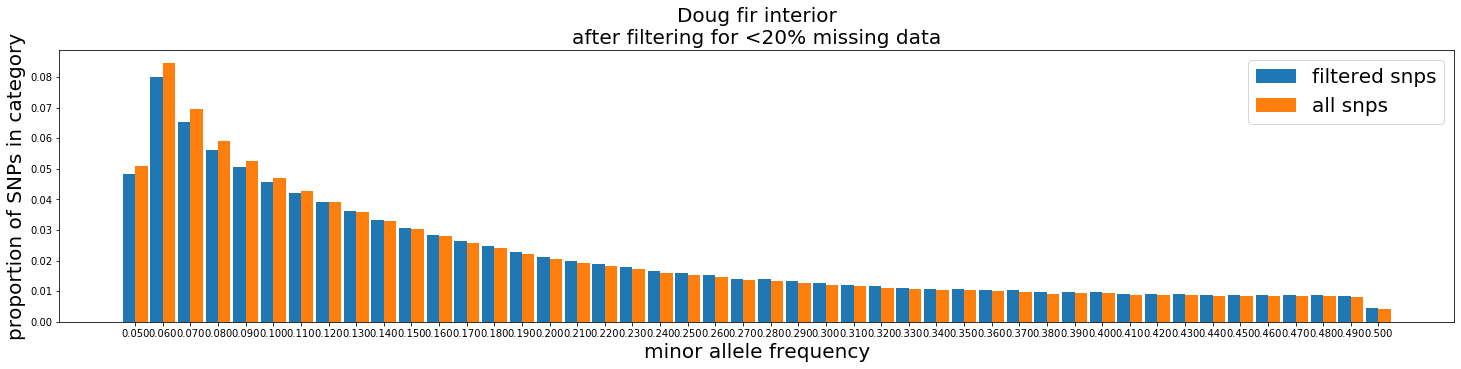

In [30]:
# compare MAF spectrum between no-missing and precursor
# MIGHT AS WELL KEEP LOCI WITHOUT FILTERING FOR MISSING DATA
make_mafdict_fig(get_mafdict(reduced.loc[perc_loci, 'AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir interior\nafter filtering for <20% missing data')

<center> SETTING PERC TO 0.25 MEANS NO LOCI WERE FILTERED BY MAF
    
    if I tried filtering < 25% missing data, the MAF spectrum looked weird, leaving the code inplace.

#### choose one snp per contig at random

In [34]:
len(lview)

56

In [35]:
def choose_random_loci(df):
    """For each chrom in df['CHROM'], randomly choose 1 snp."""
    import pandas
    import random

    keep = []
    for chrom in uni(df['CHROM']):
        loci = df.loc[chrom, 'locus']
        if isinstance(loci, str):
            keep.append(loci)
            continue
        loci = loci.tolist()
        random.shuffle(loci)
        keep.append(loci[0])
    return keep
        
dview['uni'] = uni

In [36]:
# how many chroms do I send to a job? A: math.ceil(476.42)
luni(reduced['CHROM']), luni(reduced['CHROM'])/len(lview)

(25840, 461.42857142857144)

In [37]:
# change the index for easy sending
reduced['locus'] = reduced.index.tolist()
reduced.index = reduced['CHROM'].tolist()

In [38]:
nrow(reduced), luni(reduced['locus'])

(819096, 819096)

In [39]:
# choose random loci in parallel
jobs = []
tosend = []
i = 0
numchroms = luni(reduced['CHROM'])
for chrom in tnb(uni(reduced['CHROM'])):
    tosend.append(chrom)
    if len(tosend) == 462 or (i+1)==numchroms:
        jobs.append(lview.apply_async(choose_random_loci, reduced.loc[tosend, :]))
        tosend = []
    i += 1
watch_async(jobs)

56
56


In [40]:
# get returns from jobs
randomloci = []
for j in jobs:
    randomloci.extend(j.r)
len(randomloci) == luni(reduced['CHROM'])

True

In [41]:
# reset index, reduce reduced to only randomloci
red = reduced[reduced['locus'].isin(randomloci)].copy()
print(nrow(red), len(randomloci))
red.head()

25840 25840


,DF_p1.FREQ,DF_p2.FREQ,DF_p23.FREQ,DF_p24.FREQ,DF_p25.FREQ,DF_p26.FREQ,DF_p27.FREQ,DF_p28.FREQ,DF_p10.FREQ,DF_p29.FREQ,DF_p30.FREQ,DF_p31.FREQ,DF_p32.FREQ,DF_p11.FREQ,DF_p12.FREQ,DF_p50.FREQ,DF_p51.FREQ,DF_p52.FREQ,DF_p53.FREQ,DF_p13.FREQ,DF_p72.FREQ,DF_p14.FREQ,DF_p73.FREQ,DF_p74.FREQ,DF_p75.FREQ,DF_p76.FREQ,DF_p77.FREQ,DF_p78.FREQ,DF_p79.FREQ,DF_p80.FREQ,DF_p81.FREQ,DF_p15.FREQ,DF_p82.FREQ,DF_p83.FREQ,DF_p84.FREQ,DF_p90.FREQ,DF_p16.FREQ,DF_p91.FREQ,DF_p92.FREQ,DF_p93.FREQ,DF_p95.FREQ,DF_p96.FREQ,DF_p97.FREQ,DF_p98.FREQ,DF_p17.FREQ,CHROM,AF,MAF,locus
jcf7190000000004,33.66%,30.43%,42.25%,26.25%,22.78%,23.08%,21.31%,37.68%,27.27%,49.38%,39.53%,29.31%,8%,44.44%,54.24%,30.65%,24%,1.75%,1.64%,34.21%,25.61%,25.37%,20%,38.18%,27.78%,36.71%,32.32%,21.18%,15.79%,31%,47.47%,23.29%,22.5%,20.59%,40%,41.18%,27.27%,24.39%,39.62%,18.97%,20.88%,36.25%,30.67%,54.1%,10.34%,jcf7190000000004,0.291710,0.291710,jcf7190000000004-480197
jcf7190000000008,63.33%,63.64%,70.18%,65.48%,66.25%,58.49%,68.52%,43.33%,66.18%,57.75%,68.06%,58.82%,72.34%,69.81%,82%,65.38%,58.54%,36.36%,58.97%,71.19%,56.9%,51.79%,54.17%,55.77%,46.51%,65.28%,83.82%,55.26%,60.71%,67.61%,68.97%,64.91%,64.38%,54.65%,73.33%,53.23%,67.03%,70.77%,72.22%,68.97%,56.16%,50.77%,75.81%,49.12%,41.67%,jcf7190000000008,0.620758,0.379242,jcf7190000000008-158000
jcf7190000000011,9.15%,16.92%,8.97%,7.85%,11.9%,7.42%,8.82%,14.29%,5.81%,11.79%,14.91%,13.39%,17.76%,10.95%,20.46%,4.72%,13.56%,13.19%,12.21%,11.96%,10.7%,14.34%,14.76%,11.03%,7.4%,15.21%,13.55%,12.39%,11.86%,10.32%,17.51%,8.53%,12.96%,9.62%,11.45%,11.56%,16.2%,10.97%,17.7%,11.79%,12.67%,7.57%,11.35%,11.37%,15.56%,jcf7190000000011,0.121100,0.121100,jcf7190000000011-190565
jcf7190000000019,13.83%,0%,7.14%,NaN,3.12%,7.69%,14.29%,9.52%,6.15%,1.72%,NaN,3.23%,3.85%,4.69%,24.32%,3.8%,0%,5.33%,7.55%,NaN,2.61%,2.94%,13.56%,9.09%,NaN,4.92%,11.11%,NaN,NaN,4.76%,1.28%,5.17%,NaN,8.25%,9.09%,6.06%,4.82%,NaN,NaN,1.82%,3.6%,7.02%,NaN,7.84%,2.33%,jcf7190000000019,0.063646,0.063646,jcf7190000000019-15526
jcf7190000000023,94.37%,100%,87.93%,92.63%,92.65%,95.24%,87.5%,90.41%,87.18%,92.75%,93.98%,98.18%,87.04%,95.95%,98.92%,95.77%,95.24%,97.37%,98.21%,93.1%,90.7%,97.65%,92.68%,92.73%,88.46%,77.42%,82.47%,93.75%,93.85%,98.65%,94.94%,86.89%,92.31%,80.87%,97.44%,95.65%,94.85%,90.28%,97.14%,97.33%,96.43%,92.39%,96.88%,93.65%,100%,jcf7190000000023,0.930815,0.069185,jcf7190000000023-5796


In [42]:
# reset index
reduced = red.copy()
reduced.index = reduced['locus'].tolist()
reduced.shape

(25840, 49)

46
46


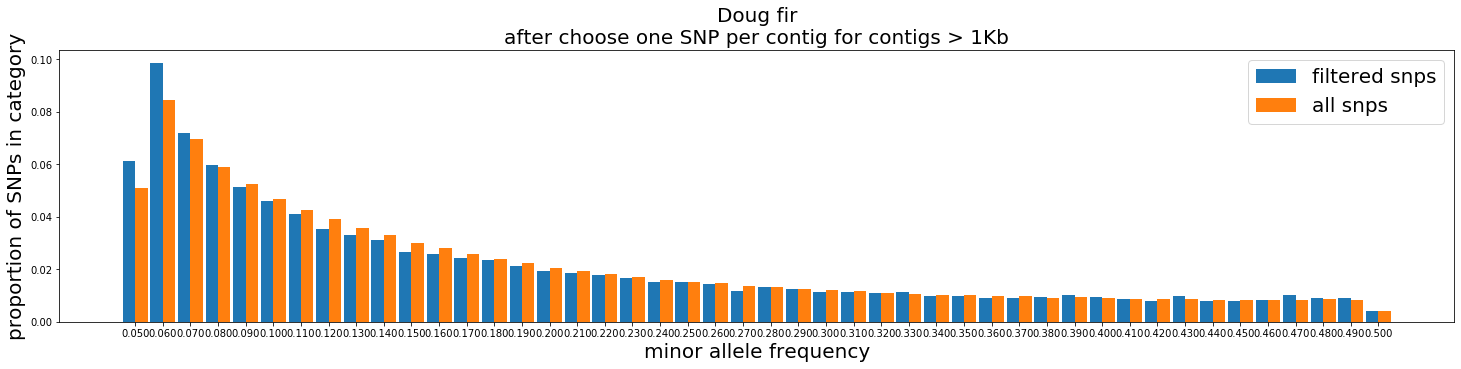

In [43]:
# compare distributions
make_mafdict_fig(get_mafdict(reduced['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir\nafter choose one SNP per contig for contigs > 1Kb')

#### get an idea of r2 values so we can determine an empirical high-end cutoff

In [44]:
len(lview)

56

In [45]:
def getfreqs(myloci):
    """Get the population ALT frequency as a float (reported as a str in table).
    
    Returns
    -------
    list of tuples
        - first element = locus name
        - second element = pandas.Series
    """
    rets = []
    for locus in myloci:
        rets.append((locus, reduced.loc[locus, freqcols].str.replace("%", "").astype(float) / 100))
    return rets
dview['getfreqs'] = getfreqs
dview['freqcols'] = freqcols
dview['reduced'] = reduced[freqcols]

def getr2(myloci):
    from scipy.stats import pearsonr
    from numpy import logical_or
    from tqdm.notebook import tqdm as nb

    freqs = dict((locus, freqs) for (locus,freqs) in getfreqs(myloci))

    r2vals = []
    i = 0
    for locusi in nb(myloci):
        for j,locusj in enumerate(myloci):
            if i < j:
                nas = logical_or(freqs[locusi].isnull(), freqs[locusj].isnull())
                r2 = pearsonr(freqs[locusi][~nas], freqs[locusj][~nas])[0]**2
                r2vals.append(r2)
        i += 1
    return r2vals

In [46]:
jobs = send_chunks(getr2, randomloci, 240, lview)
watch_async(jobs)

108
108


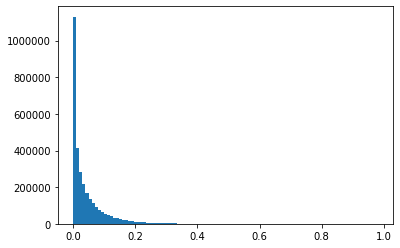

In [47]:
r2vals = []
for j in jobs:
    r2vals.extend(j.r)
plt.hist(r2vals, bins=100)
plt.show()

In [48]:
# what is 99.99th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.9999)]

0.5955499765277972

In [49]:
# get 99.9th percentile
sorted(r2vals)[math.ceil(len(r2vals)*.999)]

0.42486420727279495

In [70]:
# get 99.5th percentile
sorted(r2vals)[math.ceil(len(r2vals)*.995)]

0.31118086867179545

In [50]:
# what is 99th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.99)]

0.2631443370308384

In [51]:
# what is 98th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.98)]

0.21659108372387384

In [52]:
# what is 97th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.97)]

0.18958643302607267

In [53]:
# what perc is 0.2
for i,x in enumerate(sorted(r2vals)):
    if x > 0.2:
        print(i)
        break
(i+1)/len(r2vals)

3002457


0.9743558290172255

In [54]:
# what perc is 0.3
for i,x in enumerate(sorted(r2vals)):
    if x > 0.3:
        print(i)
        break
(i+1)/len(r2vals)

3063474


0.994157028440879

In [55]:
# what perc is 0.3606818877742702 (to compare with jack pine)
for i,x in enumerate(sorted(r2vals)):
    if x > 0.3606818877742702:
        print(i)
        break
(i+1)/len(r2vals)

3073884


0.9975352752573439

In [71]:
# use 99.5th percentile
# using 98th percentile resulted in < 1300 loci (I stopped it early)
r2thresh = 0.31118086867179545

#### LD prune random loci¶

In [57]:
reduced.shape

(25840, 49)

In [58]:
len(randomloci)

25840

In [59]:
snps.shape, reduced.shape

((821310, 94), (25840, 49))

In [60]:
len(freqcols)

45

In [75]:
lview,dview = get_client()

56 56


In [76]:
freqs = dict((locus, freqs) for (locus,freqs) in getfreqs(randomloci))
dview['freqs'] = freqs
dview['reduced'] = None
len(freqs)

25840

In [77]:
def prune_em(compareto, locusi=None, r2thresh=0.2):
    from scipy.stats import pearsonr
    from numpy import logical_or
    
    drop = []
    for locusj in compareto:
        nas = logical_or(freqs[locusi].isnull(), freqs[locusj].isnull())
        r2 = pearsonr(freqs[locusi][~nas], freqs[locusj][~nas])[0]**2
#         print('r2 = ', r2)
        if r2 > r2thresh:
            drop.append(locusj)

    return locusi,drop

In [72]:
r2thresh

0.31118086867179545

In [78]:
# send locus along with all needed loci for pairwise comparisons to engines
# each locus (job) has r2 calculated for each of the remaining unique pairwise combinations
# so the first job compares locus1 to locus2-locusn, second job locus2 to locus3-locusn ... 
jobs = []
i = 0
for locusi in tnb(randomloci):
    tosend = randomloci[i+1:]
    jobs.append(lview.apply_async(prune_em, tosend, **{'r2thresh':r2thresh, 'locusi':locusi}))
    i += 1

In [84]:
# iterate jobs, if finished jobs are an unbroken sequenced 0:(n-1), check returns and cancel any loci iterations
    # downstream. eg if locus0 has r2 > r2thresh with locus100, drop locus100 and kill jobs[100] to save some time

# found = {-1: None}  # comment this out after running this the first time in case I want to interrupt and restart
# keep = list(randomloci)  # comment this out after running this the first time in case I want to interrupt and restart
maxx = -1
while maxx < (len(randomloci) - 1):
    i = 0  # jcount
    for j in tnb(jobs):
        if j.ready() and i-1 in found.keys() and i not in found.keys():
            found[i] = True
            try:
                locusi, drop = j.r
            except: # CancelledError
                continue
            if locusi in keep:
                for locusj in drop:
                    if locusj in keep:
                        job_idx = randomloci.index(locusj)
    #                     print('\tcanceling ', job_idx, '. ', locusj, randomloci[job_idx])
                        jobs[job_idx].cancel()
                        keep.remove(locusj)
        i += 1
    maxx = max(found.keys())
    if maxx+1 < len(randomloci):
        update([(jobs[maxx+1].ready(), maxx, len(found.keys()), len(keep))])
        time.sleep(10)
len(keep)

(False, 25209, 25211, 4941)


4941

In [85]:
# combined varieties had 3591 ld-pruned loci
baydir = makedir(op.join(snpdir, 'baypass'))
pkl = op.join(baydir, 'lessthan25perc-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p3111.pkl')
pkldump(keep, pkl)

46
46


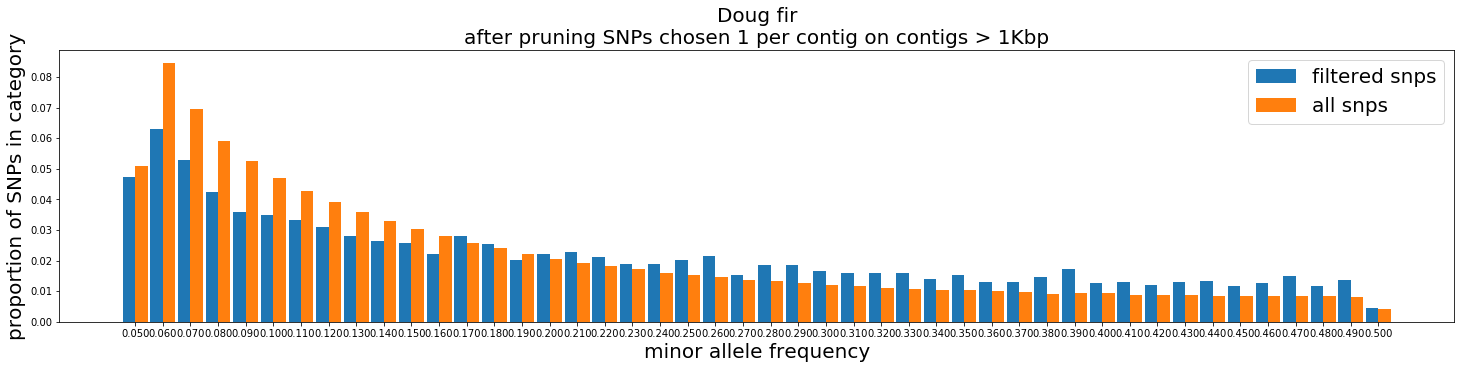

In [86]:
# compare distributions
keeping = reduced[reduced.index.isin(keep)].copy()
make_mafdict_fig(get_mafdict(keeping['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir\nafter pruning SNPs chosen 1 per contig on contigs > 1Kbp')

# create infiles to baypass to estimate neutral structure

#### <center> genotyping data

"The genotyping data file is simply organized as a matrix with
nsnp rows and 2 ∗ npop columns. The row field separator is a space. More
precisely, each row corresponds to one marker and the number of columns is
twice the number of populations because each pair of numbers corresponds to
each allele (or read counts for PoolSeq experiment) counts in one population"

In [12]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass'

In [13]:
fs(baydir, bnames=True, dirs=False)

['lessthan25perc-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p3111.pkl']

In [15]:
prunedloci = pklload(op.join(baydir, 'lessthan25perc-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p3111.pkl'))
len(prunedloci)

4941

In [9]:
# read in snps in parallel
f = keys(linenums)[0]
nrows = 50000
jobs = []
for skipto in range(0, linenums[f], nrows):
    jobs.append(lview.apply_async(get_skipto_df, *(f, skipto, nrows)))
watch_async(jobs)

48
48


In [16]:
# get pruned SNPs
snps = pd.concat([j.r for j in jobs])
snps.index = snps['locus'].tolist()
reduced = snps[snps.index.isin(prunedloci)].copy()
reduced.head()

,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,DF_p1.GT,DF_p1.GQ,DF_p1.SDP,DF_p1.DP,DF_p1.FREQ,DF_p1.PVAL,DF_p1.AD,DF_p1.RD,DF_p2.GT,DF_p2.GQ,DF_p2.SDP,DF_p2.DP,DF_p2.FREQ,DF_p2.PVAL,DF_p2.AD,DF_p2.RD,DF_p23.GT,DF_p23.GQ,DF_p23.SDP,DF_p23.DP,DF_p23.FREQ,DF_p23.PVAL,DF_p23.AD,DF_p23.RD,DF_p24.GT,DF_p24.GQ,DF_p24.SDP,DF_p24.DP,DF_p24.FREQ,DF_p24.PVAL,DF_p24.AD,DF_p24.RD,DF_p25.GT,DF_p25.GQ,DF_p25.SDP,DF_p25.DP,DF_p25.FREQ,...,DF_p93.GT,DF_p93.GQ,DF_p93.SDP,DF_p93.DP,DF_p93.FREQ,DF_p93.PVAL,DF_p93.AD,DF_p93.RD,DF_p95.GT,DF_p95.GQ,DF_p95.SDP,DF_p95.DP,DF_p95.FREQ,DF_p95.PVAL,DF_p95.AD,DF_p95.RD,DF_p96.GT,DF_p96.GQ,DF_p96.SDP,DF_p96.DP,DF_p96.FREQ,DF_p96.PVAL,DF_p96.AD,DF_p96.RD,DF_p97.GT,DF_p97.GQ,DF_p97.SDP,DF_p97.DP,DF_p97.FREQ,DF_p97.PVAL,DF_p97.AD,DF_p97.RD,DF_p98.GT,DF_p98.GQ,DF_p98.SDP,DF_p98.DP,DF_p98.FREQ,DF_p98.PVAL,DF_p98.AD,DF_p98.RD,DF_p17.GT,DF_p17.GQ,DF_p17.SDP,DF_p17.DP,DF_p17.FREQ,DF_p17.PVAL,DF_p17.AD,DF_p17.RD,locus,MAF
jcf7190000000008-158000,jcf7190000000008,158000,C,A,0.620758,-10.0,SNP,PASS,45,5,79,2,1,C/A,152.0,60,60.0,63.33%,5.260700e-16,38.0,22.0,C/A,55.0,22,22.0,63.64%,2.781700e-06,14.0,8.0,C/A,168.0,57,57.0,70.18%,1.481800e-17,40.0,17.0,C/A,224.0,84,84.0,65.48%,3.310800e-23,55.0,29.0,C/A,217.0,80,80.0,66.25%,...,C/A,166.0,58,58.0,68.97%,2.040100e-17,40.0,18.0,C/A,158.0,73,73.0,56.16%,1.563500e-16,41.0,32.0,C/A,123.0,65,65.0,50.77%,4.662400e-13,33.0,32.0,C/A,206.0,62,62.0,75.81%,2.319800e-21,47.0,15.0,C/A,103.0,57,57.0,49.12%,4.365800e-11,28.0,29.0,C/A,35.0,24,24.0,41.67%,2.998500e-04,10.0,14.0,jcf7190000000008-158000,0.379242
jcf7190000000023-5796,jcf7190000000023,5796,A,G,0.930815,-10.0,SNP,PASS,65,0,1,86,0,G/G,255.0,71,71.0,94.37%,3.261700e-36,67.0,4.0,G/G,135.0,24,24.0,100%,3.101000e-14,24.0,0.0,G/G,249.0,58,58.0,87.93%,1.133600e-25,51.0,7.0,G/G,255.0,95,95.0,92.63%,2.035700e-46,88.0,7.0,G/G,255.0,68,68.0,92.65%,...,G/G,255.0,75,75.0,97.33%,3.152100e-41,73.0,2.0,G/G,255.0,112,112.0,96.43%,4.987400e-60,108.0,4.0,G/G,255.0,92,92.0,92.39%,1.033600e-44,85.0,7.0,G/G,255.0,64,64.0,96.88%,8.955700e-35,62.0,2.0,G/G,255.0,63,63.0,93.65%,1.270100e-31,59.0,4.0,G/G,123.0,22,22.0,100%,4.752600e-13,22.0,0.0,jcf7190000000023-5796,0.069185
jcf7190000000041-27356,jcf7190000000041,27356,C,T,0.057276,-10.0,SNP,PASS,40,77,10,0,0,C/T,18.0,59,59.0,NaN,1.367400e-02,6.0,53.0,C/C,19.0,21,21.0,NaN,1.158500e-01,3.0,18.0,C/C,15.0,22,22.0,NaN,5.388500e-02,4.0,18.0,C/C,47.0,35,35.0,5.71%,2.463800e-01,2.0,33.0,C/C,81.0,44,44.0,0%,...,C/C,47.0,35,35.0,5.71%,2.463800e-01,2.0,33.0,C/C,72.0,56,56.0,5.36%,1.216200e-01,3.0,53.0,C/C,81.0,55,55.0,3.64%,2.477100e-01,2.0,53.0,C/T,15.0,48,48.0,NaN,2.787400e-02,5.0,43.0,C/C,40.0,41,41.0,9.76%,5.778400e-02,4.0,37.0,C/C,25.0,21,21.0,9.52%,2.439000e-01,2.0,19.0,jcf7190000000041-27356,0.057276
jcf7190000000044-204467,jcf7190000000044,204467,T,A,0.276106,-10.0,SNP,PASS,107,0,87,0,0,T/A,134.0,140,140.0,28.57%,3.498500e-14,40.0,100.0,T/A,19.0,26,26.0,NaN,1.130900e-02,6.0,20.0,T/A,107.0,89,89.0,34.83%,1.945500e-11,31.0,58.0,T/A,166.0,119,119.0,39.5%,2.373500e-17,47.0,72.0,T/A,60.0,119,119.0,15.97%,...,T/A,108.0,103,103.0,31.07%,1.336000e-11,32.0,71.0,T/A,72.0,158,158.0,14.56%,5.030100e-08,23.0,135.0,T/A,50.0,117,117.0,13.68%,8.806600e-06,16.0,101.0,T/A,64.0,118,118.0,16.95%,3.960500e-07,20.0,98.0,T/A,109.0,78,78.0,39.74%,1.103400e-11,31.0,47.0,T/A,63.0,45,45.0,40%,4.527800e-07,18.0,27.0,jcf7190000000044-204467,0.276106
jcf7190000000051-638525,jcf7190000000051,638525,C,T,0.693224,-10.0,SNP,PASS,109,0,55,32,0,C/T,255.0,181,181.0,66.3%,3.265100e-50,120.0,61.0,C/T,115.0,33,33.0,78.79%,2.582400e-12,26.0,7.0,C/T,255.0,90,90.0,78.89%,8.778000e-33,71.0,19.0,C/T,255.0,174,174.0,56.32%,1.088900e-38,98.0,76.0,C/T,255.0,110,110.0,70.91%,...,C/T,253.0,95,95.0,65.26%,4.739000e-26,62.0,33.0,C/T,255.0,178,178.0,73.45%,3.973100e-57,130.0,48.0,C/T,255.0,171,171.0,61.4%,1.142000e-42,105.0,66.0,C/T,255.0,142,142.0,63.38%,4.158200e-37,90.0,52.0,C/T,255.0,148,148.0,64.86%,4.997900e-40,96.0,52.0,C/T,132.0,39,39.0,

In [17]:
len(set(prunedloci).intersection(reduced.index)) == len(prunedloci)

True

In [19]:
len([col for col in reduced.columns if '.FREQ' in col])

45

In [58]:
def get_counts(loci, numpops=0):
    """Create gfile for baypass.
    
    Get read counts for global major and minor allele. Missing data = 0."""
    import pandas
    from collections import OrderedDict
    import tqdm
    
    pops = [col.replace(".FREQ","") for col in reduced.columns if '.FREQ' in col]
#     assert len(pops) == numpops
    read_counts = OrderedDict()
    for locus in tqdm.tqdm_notebook(loci):
        if reduced.loc[locus, 'AF'] > 0.5:
            # this matches calculation of MAF from 001_JP_pooled_pangenome_data_explore.ipynb
            refismajor = False
            majortag = 'AD'
            minortag = 'RD'
        else:
            refismajor = True
            majortag = 'RD'
            minortag = 'AD'
        if refismajor is True:
#             print('checking ', locus)
            # double check that it matches MAF calculation
            assert reduced.loc[locus, 'AF'] == reduced.loc[locus, 'MAF']
        for pop in pops:
            for which,tag in zip(['major','minor'],[majortag, minortag]):
                newcol = "%s-%s" % (pop,which)
                if newcol not in read_counts:
                    read_counts[newcol] = OrderedDict()
                if reduced.loc[locus, f"{pop}.FREQ"] != reduced.loc[locus, f"{pop}.FREQ"]:
                    # if locus was filtered for this pop
                    read_counts[newcol][locus] = 0
                else:
                    try:
                        read_counts[newcol][locus] = int(reduced.loc[locus, "%s.%s" % (pop, tag)])
                    except ValueError as e:
                        # missing data - probably don't need this try statement when first looking at FREQ
                        read_counts[newcol][locus] = 0
    return pandas.DataFrame(read_counts)

In [20]:
# get the gfile using the prunedloci
neutral_read_counts = get_counts(prunedloci, numpops=45)
neutral_read_counts.head()

/data/programs/brandon_anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


,DF_p1-major,DF_p1-minor,DF_p2-major,DF_p2-minor,DF_p23-major,DF_p23-minor,DF_p24-major,DF_p24-minor,DF_p25-major,DF_p25-minor,DF_p26-major,DF_p26-minor,DF_p27-major,DF_p27-minor,DF_p28-major,DF_p28-minor,DF_p10-major,DF_p10-minor,DF_p29-major,DF_p29-minor,DF_p30-major,DF_p30-minor,DF_p31-major,DF_p31-minor,DF_p32-major,DF_p32-minor,DF_p11-major,DF_p11-minor,DF_p12-major,DF_p12-minor,DF_p50-major,DF_p50-minor,DF_p51-major,DF_p51-minor,DF_p52-major,DF_p52-minor,DF_p53-major,DF_p53-minor,DF_p13-major,DF_p13-minor,DF_p72-major,DF_p72-minor,DF_p14-major,DF_p14-minor,DF_p73-major,DF_p73-minor,DF_p74-major,DF_p74-minor,DF_p75-major,DF_p75-minor,DF_p76-major,DF_p76-minor,DF_p77-major,DF_p77-minor,DF_p78-major,DF_p78-minor,DF_p79-major,DF_p79-minor,DF_p80-major,DF_p80-minor,DF_p81-major,DF_p81-minor,DF_p15-major,DF_p15-minor,DF_p82-major,DF_p82-minor,DF_p83-major,DF_p83-minor,DF_p84-major,DF_p84-minor,DF_p90-major,DF_p90-minor,DF_p16-major,DF_p16-minor,DF_p91-major,DF_p91-minor,DF_p92-major,DF_p92-minor,DF_p93-major,DF_p93-minor,DF_p95-major,DF_p95-minor,DF_p96-major,DF_p96-minor,DF_p97-major,DF_p97-minor,DF_p98-major,DF_p98-minor,DF_p17-major,DF_p17-minor
jcf7190000126089-55948,83,9,26,2,77,1,94,11,70,8,69,7,85,15,75,7,84,9,0,0,66,25,0,0,0,0,83,7,69,28,77,2,43,10,76,11,57,32,0,0,87,4,61,2,91,7,62,3,45,10,76,1,100,4,0,0,0,0,0,0,108,0,74,3,102,2,100,13,42,2,0,0,95,16,106,7,66,2,0,0,121,4,85,7,83,15,65,2,25,3
jcf7190000026028-845821,96,43,20,12,54,29,81,35,63,49,61,29,92,28,61,38,66,44,71,38,81,39,52,22,55,35,79,44,78,28,64,17,60,20,52,37,81,29,82,25,67,27,80,42,73,24,48,22,88,37,85,28,126,40,94,47,78,34,102,28,97,24,54,38,88,32,98,51,36,18,37,24,113,34,86,37,58,25,70,19,97,35,87,31,88,34,71,39,25,12
jcf7190000087984-188641,66,2,24,2,46,8,0,0,0,0,47,12,0,0,0,0,0,0,65,3,0,0,31,3,51,3,46,4,33,7,46,1,43,1,38,4,0,0,38,1,72,1,47,2,43,1,41,0,33,1,54,2,62,1,0,0,45,3,48,2,54,3,36,1,48,3,77,4,37,3,36,3,44,1,39,0,37,0,53,7,55,1,56,2,39,3,51,3,31,1
jcf7190000066171-329714,96,4,27,1,72,8,0,0,96,8,69,9,87,9,71,7,76,9,60,8,90,10,67,11,78,7,82,3,110,0,70,14,67,11,56,21,100,4,79,11,78,0,93,10,86,2,58,2,108,3,92,17,0,0,99,8,77,3,118,10,104,13,56,10,109,19,92,13,0,0,65,8,110,9,96,23,62,11,63,10,126,16,85,4,112,2,82,7,30,1
jcf7190000086747-243798,86,13,0,0,0,0,61,29,53,18,77,7,42,12,51,10,0,0,35,8,57,13,0,0,33,12,52,15,96,1,69,9,44,9,0,0,74,4,71,10,63,13,53,11,62,3,44,3,72,11,66,12,75,20,0,0,73,12,89,8,77,12,59,10,0,0,80,11,18,2,37,10,81,0,70,16,42,7,44,9,107,7,65,3,57,12,74,0,0,0


In [21]:
# assert that DP = RD + AD
dpcols = [col for col in reduced.columns if '.DP' in col]
for dpcol in dpcols:
    pop = dpcol.split(".")[0]
    adcol = f"{pop}.AD"
    rdcol = f"{pop}.RD"
    assert all(reduced[dpcol] == (reduced[adcol]+reduced[rdcol]))

In [22]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass'

In [23]:
# make sure missing data makes sense
majorcols = [col for col in neutral_read_counts.columns if 'major' in col]
print(len(majorcols))
for locus in neutral_read_counts.index:
    misscount = 0
    for col in majorcols:
        pop = col.split("-")[0]
        if neutral_read_counts.loc[locus, col] == 0 and neutral_read_counts.loc[locus, "%s-minor" % pop] == 0:
            misscount += 1
    if misscount / len(majorcols) > 0.25:
        print('crap ', locus)

45


In [24]:
# save
neutral_read_counts.to_csv(op.join(baydir, 'coastal_neutral_gfile_HEADERIDX.txt'), sep='\t', index=True)
neutral_read_counts.to_csv(op.join(baydir, 'coastal_neutral_gfile_noheaderidx.txt'), sep='\t', index=False, header=False)

#### <center> poolsizefile

"For Pool–Seq experiment, the haploid size (twice the number of pooled in- dividuals for diploid species) of each population should be provided. ... The order of the populations in the pool size file must be the same as in the allele count (and the covariate) data file(s)."

In [25]:
DIR

'/data/projects/pool_seq/DF_datasets'

In [26]:
# the reason the ploidy.keys() are not in same order of table ...
# ... is because varscan puts Sample1.X then Sample10.X ... (JP_p31 is the 10th file into varscan)
ploidy = pklload(op.join(DIR, 'DF_pooled_GEA/DF_pooled/pkl_files/ploidy.pkl'))['DF_pooled']
count = 0
for k,v in ploidy.items():
    print(k,v)
    count += 1
    if count == 5:
        break

DF_p1 80
DF_p10 80
DF_p11 80
DF_p12 80
DF_p13 80


In [27]:
# get ploidy of pops in same order as in gfile
pops = [col.replace("-major","") for col in neutral_read_counts.columns if '-major' in col]
vals = OrderedDict()
for pop in pops:
    vals[pop] = OrderedDict()
    vals[pop][0] = ploidy[pop]
poolsizefile = pd.DataFrame(vals)
poolsizefile

,DF_p1,DF_p2,DF_p23,DF_p24,DF_p25,DF_p26,DF_p27,DF_p28,DF_p10,DF_p29,DF_p30,DF_p31,DF_p32,DF_p11,DF_p12,DF_p50,DF_p51,DF_p52,DF_p53,DF_p13,DF_p72,DF_p14,DF_p73,DF_p74,DF_p75,DF_p76,DF_p77,DF_p78,DF_p79,DF_p80,DF_p81,DF_p15,DF_p82,DF_p83,DF_p84,DF_p90,DF_p16,DF_p91,DF_p92,DF_p93,DF_p95,DF_p96,DF_p97,DF_p98,DF_p17
0,80,80,80,80,80,76,80,80,80,78,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,66,80,80,78,80,78,80,80,80,80,80,80,80,80,80,80


In [28]:
# compare pop order to poolsizefile
neutral_read_counts.head()

,DF_p1-major,DF_p1-minor,DF_p2-major,DF_p2-minor,DF_p23-major,DF_p23-minor,DF_p24-major,DF_p24-minor,DF_p25-major,DF_p25-minor,DF_p26-major,DF_p26-minor,DF_p27-major,DF_p27-minor,DF_p28-major,DF_p28-minor,DF_p10-major,DF_p10-minor,DF_p29-major,DF_p29-minor,DF_p30-major,DF_p30-minor,DF_p31-major,DF_p31-minor,DF_p32-major,DF_p32-minor,DF_p11-major,DF_p11-minor,DF_p12-major,DF_p12-minor,DF_p50-major,DF_p50-minor,DF_p51-major,DF_p51-minor,DF_p52-major,DF_p52-minor,DF_p53-major,DF_p53-minor,DF_p13-major,DF_p13-minor,DF_p72-major,DF_p72-minor,DF_p14-major,DF_p14-minor,DF_p73-major,DF_p73-minor,DF_p74-major,DF_p74-minor,DF_p75-major,DF_p75-minor,DF_p76-major,DF_p76-minor,DF_p77-major,DF_p77-minor,DF_p78-major,DF_p78-minor,DF_p79-major,DF_p79-minor,DF_p80-major,DF_p80-minor,DF_p81-major,DF_p81-minor,DF_p15-major,DF_p15-minor,DF_p82-major,DF_p82-minor,DF_p83-major,DF_p83-minor,DF_p84-major,DF_p84-minor,DF_p90-major,DF_p90-minor,DF_p16-major,DF_p16-minor,DF_p91-major,DF_p91-minor,DF_p92-major,DF_p92-minor,DF_p93-major,DF_p93-minor,DF_p95-major,DF_p95-minor,DF_p96-major,DF_p96-minor,DF_p97-major,DF_p97-minor,DF_p98-major,DF_p98-minor,DF_p17-major,DF_p17-minor
jcf7190000126089-55948,83,9,26,2,77,1,94,11,70,8,69,7,85,15,75,7,84,9,0,0,66,25,0,0,0,0,83,7,69,28,77,2,43,10,76,11,57,32,0,0,87,4,61,2,91,7,62,3,45,10,76,1,100,4,0,0,0,0,0,0,108,0,74,3,102,2,100,13,42,2,0,0,95,16,106,7,66,2,0,0,121,4,85,7,83,15,65,2,25,3
jcf7190000026028-845821,96,43,20,12,54,29,81,35,63,49,61,29,92,28,61,38,66,44,71,38,81,39,52,22,55,35,79,44,78,28,64,17,60,20,52,37,81,29,82,25,67,27,80,42,73,24,48,22,88,37,85,28,126,40,94,47,78,34,102,28,97,24,54,38,88,32,98,51,36,18,37,24,113,34,86,37,58,25,70,19,97,35,87,31,88,34,71,39,25,12
jcf7190000087984-188641,66,2,24,2,46,8,0,0,0,0,47,12,0,0,0,0,0,0,65,3,0,0,31,3,51,3,46,4,33,7,46,1,43,1,38,4,0,0,38,1,72,1,47,2,43,1,41,0,33,1,54,2,62,1,0,0,45,3,48,2,54,3,36,1,48,3,77,4,37,3,36,3,44,1,39,0,37,0,53,7,55,1,56,2,39,3,51,3,31,1
jcf7190000066171-329714,96,4,27,1,72,8,0,0,96,8,69,9,87,9,71,7,76,9,60,8,90,10,67,11,78,7,82,3,110,0,70,14,67,11,56,21,100,4,79,11,78,0,93,10,86,2,58,2,108,3,92,17,0,0,99,8,77,3,118,10,104,13,56,10,109,19,92,13,0,0,65,8,110,9,96,23,62,11,63,10,126,16,85,4,112,2,82,7,30,1
jcf7190000086747-243798,86,13,0,0,0,0,61,29,53,18,77,7,42,12,51,10,0,0,35,8,57,13,0,0,33,12,52,15,96,1,69,9,44,9,0,0,74,4,71,10,63,13,53,11,62,3,44,3,72,11,66,12,75,20,0,0,73,12,89,8,77,12,59,10,0,0,80,11,18,2,37,10,81,0,70,16,42,7,44,9,107,7,65,3,57,12,74,0,0,0


In [29]:
# save, no need to name as 'neutral'
poolsizefile.to_csv(op.join(baydir, 'coastal_poolsizefile_HEADERIDX.txt'), sep='\t', index=False)
poolsizefile.to_csv(op.join(baydir, 'coastal_poolsizefile_noheaderidx.txt'), sep='\t', index=False, header=False)

#### <center> create random runs

In [30]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass'

In [32]:
import random

for i in range(5):
    print(random.randint(1,100000000))

88638996
84417116
71164152
55812613
19802419


#### estimate covariance matrix (run in bash)
```bash
cd /data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass
mkdir neutral_runs
cd neutral_runs

export gfile="/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/coastal_neutral_gfile_noheaderidx.txt"

export poolsizefile="/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/coastal_poolsizefile_noheaderidx.txt"



# These commands took about XXXXXX hours each to complete


# chain 1
/data/programs/baypass_2.2/sources/g_baypass -gfile $gfile -poolsizefile $poolsizefile \
-nthreads 8 -seed 88638996 -print_omega_samples -nval 30000 -outprefix chain_1

# chain 2
/data/programs/baypass_2.2/sources/g_baypass -gfile $gfile -poolsizefile $poolsizefile \
-nthreads 8 -seed 84417116 -print_omega_samples -nval 30000 -outprefix chain_2

# chain 3
/data/programs/baypass_2.2/sources/g_baypass -gfile $gfile -poolsizefile $poolsizefile \
-nthreads 8 -seed 71164152 -print_omega_samples -nval 30000 -outprefix chain_3

# chain 4
/data/programs/baypass_2.2/sources/g_baypass -gfile $gfile -poolsizefile $poolsizefile \
-nthreads 8 -seed 55812613 -print_omega_samples -nval 30000 -outprefix chain_4

# chain 5
/data/programs/baypass_2.2/sources/g_baypass -gfile $gfile -poolsizefile $poolsizefile \
-nthreads 8 -seed 19802419 -print_omega_samples -nval 30000 -outprefix chain_5

```

# look at covariance matrices output from chains

In [ ]:
from pythonimports import *

In [ ]:
baydir = '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass'

In [ ]:
# get the matrix files output for each chain
ndir = op.join(baydir, 'neutral_runs')
mfiles = fs(ndir, 'mat_omega.out')
mfiles

In [ ]:
# get a list of values by vectorizing the matrix for each chain
matrices = {}
for m in mfiles:
    chain = op.basename(m).split("_mat")[0]
    text = read(m)
    rows = []
    for line in text:
        rows.extend([float(val) for val in line.split()])
    matrices[chain] = rows
len(matrices[chain])

In [ ]:
np.sqrt(7569)  # num pops

In [ ]:
from scipy.stats import pearsonr

In [ ]:
# look at pairwise correlations among chains
for i,chaini in enumerate(matrices):
    for j,chainj in enumerate(matrices):
        if i < j:
            print(chaini,chainj,pearsonr(matrices[chaini], matrices[chainj]))

In [ ]:
# plot pairwise chains agains 1:1 line, print slope and intercept from data

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

for i,chaini in enumerate(matrices):
    for j,chainj in enumerate(matrices):
        if i < j:
            slope, intercept = np.polyfit(matrices[chaini], matrices[chainj], 1)
            print(chaini, chainj, slope, intercept)
            fig, ax = plt.subplots(figsize=(5,5))
            ax.scatter(matrices[chaini], matrices[chainj])
            ax.set_xlabel(chaini)
            ax.set_ylabel(chainj)
            line = mlines.Line2D([0, 1], [0, 1], color='red')
            transform = ax.transAxes
            line.set_transform(transform)
            ax.add_line(line)           
            
            plt.show()

In [ ]:
# make a matrix with the average across matrices
mats = {}
for m in mfiles:
    chain = op.basename(m).split("_mat")[0]
    mats[chain] = pd.read_table(m, delim_whitespace=True, header=None)
mats[chain].head()

In [ ]:
for chain,m in mats.items():
    print(chain)
    if chain == 'chain_1':
        summatrix = np.array(m)
    else:
        summatrix = summatrix + np.array(m)
summatrix

In [ ]:
avg = summatrix / len(mats)
avg.shape

In [ ]:
avgmat = pd.DataFrame(avg)
print(avgmat.shape)
avgmat.head()

In [ ]:
# make sure avgmat is highly correlated with other chains
avgmatlst = []
for row in avgmat.index:
    for col in avgmat.columns:
        avgmatlst.append(avgmat.loc[row, col])
print(len(avgmatlst), len(matrices[chain]))

for chain,lst in matrices.items():
    print(chain, pearsonr(matrices[chain], avgmatlst))

#### make sure pops are in same order as gfile

In [ ]:
poolsizefile = pd.read_table(op.join(baydir, 'poolsizefile_HEADERIDX.txt'))
poolsizefile

In [ ]:
gfile = pd.read_table(op.join(baydir, 'coastal_neutral_gfile_HEADERIDX.txt'), index_col=0)
gfilecols = [list(gfile.columns)[i].split("-")[0] for i in range(0,len(gfile.columns),2)]
pd.DataFrame(columns=gfilecols)  # just so it prints pretty

In [ ]:
list(poolsizefile.columns) == gfilecols

In [ ]:
# now apply to avgmat
avgmat.columns = gfilecols
avgmat.index = gfilecols
avgmat.head()

In [ ]:
# save avgmatrix
avgmat.to_csv(op.join(baydir, 'interior_neutral_omegafile_HEADERIDX.txt'), sep='\t', index=True, header=True)
avgmat.to_csv(op.join(baydir, 'interior_neutral_omegafile_noheaderidx.txt'), sep='\t', index=False, header=False)

# make efile

In [34]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass'

In [35]:
poolsizefile

,DF_p1,DF_p2,DF_p23,DF_p24,DF_p25,DF_p26,DF_p27,DF_p28,DF_p10,DF_p29,DF_p30,DF_p31,DF_p32,DF_p11,DF_p12,DF_p50,DF_p51,DF_p52,DF_p53,DF_p13,DF_p72,DF_p14,DF_p73,DF_p74,DF_p75,DF_p76,DF_p77,DF_p78,DF_p79,DF_p80,DF_p81,DF_p15,DF_p82,DF_p83,DF_p84,DF_p90,DF_p16,DF_p91,DF_p92,DF_p93,DF_p95,DF_p96,DF_p97,DF_p98,DF_p17
0,80,80,80,80,80,76,80,80,80,78,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,66,80,80,78,80,78,80,80,80,80,80,80,80,80,80,80


In [36]:
envdata = pd.read_table('/data/projects/pool_seq/environemental_data/df_std_env-19variables.txt')
envdata

,prov,our_id,Variety,LONG,LAT,Elevation,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD
0,1,DF_p1,FDC,-126.63,49.78,-1.291837,0.642273,-0.351203,1.051691,-1.443853,3.058223,3.763300,-1.308553,-0.982819,-0.948176,0.115574,1.163143,-1.134312,1.021369,1.099211,-0.018522,1.190196,-0.816847,-0.573470,-1.758076
1,2,DF_p2,FDC,-122.73,50.32,-0.543644,-0.130593,0.022847,-0.233176,0.291294,-0.358888,-0.472262,-0.174552,-0.008026,0.005229,-0.140720,-0.155659,-0.199673,-0.228767,-0.023166,0.454869,-0.168208,-0.067660,-0.233095,0.124388
2,3,DF_p3,FDI,-115.62,50.54,1.700937,-1.642723,-1.379842,-1.441336,1.054759,-0.817183,0.263025,0.124412,-0.581866,1.845937,-1.374266,-1.421709,1.482677,-1.435795,-1.489127,0.083687,-1.505049,-1.092863,-0.945955,-0.864381
3,4,DF_p4,FDI,-122.33,52.04,0.262103,-0.869856,-0.491472,-1.153679,1.147301,-1.054945,-0.694380,1.608922,0.087614,1.024737,-0.663727,-0.929356,0.688234,-0.961605,-0.847769,-0.518811,-1.170839,-0.185953,-0.624847,0.396934
4,5,DF_p5,FDI,-119.05,49.02,0.153903,-0.164196,0.630678,-0.578365,1.008489,-1.119267,-0.885861,2.732614,0.554780,0.307776,0.128076,-0.507339,0.127451,-0.530524,-0.343845,-0.782404,-0.588666,0.918113,0.235722,1.328658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,94,DF_p94,FDI,-117.20,51.40,0.522244,-1.172282,-0.678497,-1.249565,1.170436,-0.802251,-0.548854,0.299667,-0.076077,1.367963,-0.895017,-0.982108,0.688234,-1.004713,-0.870675,0.444110,-1.181620,-0.698554,-0.862467,0.010300
84,95,DF_p95,FDC,-123.89,43.40,-1.317161,1.448742,0.350141,1.569474,-1.721477,0.651888,-0.242485,-0.659079,-0.114701,-1.154111,1.384542,1.743416,-1.835291,1.754207,1.855097,-1.126689,1.599873,0.523804,0.967849,0.149741
85,96,DF_p96,FDC,-122.81,46.25,-1.179033,1.112714,0.443653,1.128400,-1.143094,0.287779,0.178774,-0.504443,-0.326213,-1.034618,0.928214,1.127975,-0.713724,0.892044,0.824343,-0.970685,1.093167,0.720958,0.865094,-0.084774
86,97,DF_p97,FDC,-122.49,44.13,-0.967237,1.482345,1.238510,1.262640,-0.911741,0.110893,-0.280781,-0.287952,0.048990,-1.082924,1.672092,1.251064,-0.853920,1.064477,0.984682,-1.083653,1.179415,1.785592,1.744930,0.903995


In [37]:
# double check centered/standardized
for env in list(envdata.columns)[6:]:
    print(env, np.mean(envdata[env]), np.std(envdata[env]))

MAT -3.027880976250427e-17 0.9943019479194252
MWMT 5.551115123125783e-17 0.9943019479194254
MCMT -3.7343865373755267e-16 0.9943019479194254
TD 4.945538927875697e-16 0.9943019479194257
MAP 1.3625464393126921e-16 0.9943019479194254
MSP 7.569702440626067e-18 0.9943019479194252
AHM 6.055761952500853e-17 0.994301947919426
SHM 1.0092936587501423e-17 0.9943019479194254
DD_0 -2.0185873175002846e-16 0.9943019479194254
DD5 -3.6334571715005125e-16 0.9943019479194255
NFFD -1.8167285857502563e-16 0.9943019479194248
bFFP -7.87249053825111e-16 0.9943019479194257
eFFP -4.440892098500626e-16 0.994301947919425
FFP 8.074349270001139e-17 0.9943019479194252
PAS 1.2111523905001707e-16 0.9943019479194257
EMT 4.0371746350005693e-17 0.9943019479194254
EXT -1.2918958832001822e-15 0.9943019479194253
Eref 3.0783456591879343e-16 0.9943019479194255
CMD -4.289498049688105e-17 0.9943019479194252


In [38]:
# convert jp envdata to efile, making sure to order pops in same order as other files
envdata.index = envdata['our_id'].tolist()
efile = envdata.loc[poolsizefile.columns.tolist(), list(envdata.columns)[6:]]
efile.head()

,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD
DF_p1,0.642273,-0.351203,1.051691,-1.443853,3.058223,3.763300,-1.308553,-0.982819,-0.948176,0.115574,1.163143,-1.134312,1.021369,1.099211,-0.018522,1.190196,-0.816847,-0.573470,-1.758076
DF_p2,-0.130593,0.022847,-0.233176,0.291294,-0.358888,-0.472262,-0.174552,-0.008026,0.005229,-0.140720,-0.155659,-0.199673,-0.228767,-0.023166,0.454869,-0.168208,-0.067660,-0.233095,0.124388
DF_p23,0.877493,0.022847,1.185931,-1.420718,1.388146,1.220431,-1.009589,-0.675667,-1.014279,0.515643,1.514824,-1.741827,1.323126,1.557323,-0.690953,1.438158,-0.146522,-0.393649,-1.193970
DF_p24,0.306244,-0.164178,0.591440,-0.796065,2.642427,1.978696,-1.287934,-0.811771,-0.719359,-0.109465,0.600455,-0.573528,0.676504,0.641098,1.251027,0.726613,-0.461969,-0.489982,-1.403133
DF_p25,0.877493,0.303385,0.917451,-0.958012,1.358282,1.940400,-0.999280,-0.769468,-0.940549,0.651083,1.286232,-1.741827,1.236909,1.511512,-0.508052,1.071605,-0.107091,-0.310161,-1.517222


In [39]:
# compare to above to make sure it copied over OK
envdata.loc[poolsizefile.columns.tolist(), :].head()

,prov,our_id,Variety,LONG,LAT,Elevation,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD
DF_p1,1,DF_p1,FDC,-126.63,49.78,-1.291837,0.642273,-0.351203,1.051691,-1.443853,3.058223,3.763300,-1.308553,-0.982819,-0.948176,0.115574,1.163143,-1.134312,1.021369,1.099211,-0.018522,1.190196,-0.816847,-0.573470,-1.758076
DF_p2,2,DF_p2,FDC,-122.73,50.32,-0.543644,-0.130593,0.022847,-0.233176,0.291294,-0.358888,-0.472262,-0.174552,-0.008026,0.005229,-0.140720,-0.155659,-0.199673,-0.228767,-0.023166,0.454869,-0.168208,-0.067660,-0.233095,0.124388
DF_p23,23,DF_p23,FDC,-126.88,50.33,-1.669388,0.877493,0.022847,1.185931,-1.420718,1.388146,1.220431,-1.009589,-0.675667,-1.014279,0.515643,1.514824,-1.741827,1.323126,1.557323,-0.690953,1.438158,-0.146522,-0.393649,-1.193970
DF_p24,24,DF_p24,FDC,-125.25,49.33,-0.757742,0.306244,-0.164178,0.591440,-0.796065,2.642427,1.978696,-1.287934,-0.811771,-0.719359,-0.109465,0.600455,-0.573528,0.676504,0.641098,1.251027,0.726613,-0.461969,-0.489982,-1.403133
DF_p25,25,DF_p25,FDC,-122.48,49.28,-1.459893,0.877493,0.303385,0.917451,-0.958012,1.358282,1.940400,-0.999280,-0.769468,-0.940549,0.651083,1.286232,-1.741827,1.236909,1.511512,-0.508052,1.071605,-0.107091,-0.310161,-1.517222


In [40]:
######################### VERY IMPORTANT!
# transpose df so pops are columns and env are rows
#########################
efile = efile.T
efile.head()

,DF_p1,DF_p2,DF_p23,DF_p24,DF_p25,DF_p26,DF_p27,DF_p28,DF_p10,DF_p29,DF_p30,DF_p31,DF_p32,DF_p11,DF_p12,DF_p50,DF_p51,DF_p52,DF_p53,DF_p13,DF_p72,DF_p14,DF_p73,DF_p74,DF_p75,DF_p76,DF_p77,DF_p78,DF_p79,DF_p80,DF_p81,DF_p15,DF_p82,DF_p83,DF_p84,DF_p90,DF_p16,DF_p91,DF_p92,DF_p93,DF_p95,DF_p96,DF_p97,DF_p98,DF_p17
MAT,0.642273,-0.130593,0.877493,0.306244,0.877493,0.608670,-0.130593,0.239039,0.608670,1.011905,0.407053,0.675876,-0.298607,-0.231402,-0.634636,1.717565,1.482345,2.154403,0.911096,-0.197799,0.709479,1.583154,-0.130593,-0.029784,-0.601033,-0.399416,0.171833,1.415139,1.784771,1.515948,1.213522,1.045508,0.978302,0.911096,0.911096,0.474259,0.944699,0.071024,0.675876,0.743082,1.448742,1.112714,1.482345,1.280728,1.045508
MWMT,-0.351203,0.022847,0.022847,-0.164178,0.303385,0.116359,-1.286329,-0.959035,0.116359,0.303385,1.098241,1.519048,-1.052548,-0.912279,-1.052548,2.360661,2.267148,3.062005,1.332023,-1.052548,1.098241,0.209872,-0.631741,-0.631741,-0.818766,-1.005791,-0.725254,1.238510,1.425535,1.144998,-0.164178,-0.117422,-0.444716,0.303385,0.490410,-0.023909,0.350141,0.256628,0.209872,0.116359,0.350141,0.443653,1.238510,0.537166,1.846342
MCMT,1.051691,-0.233176,1.185931,0.591440,0.917451,0.879097,0.476377,0.898274,0.783212,0.994160,-0.175645,0.035303,0.284606,0.399669,-0.386594,1.358526,1.090046,1.492765,0.936629,0.246252,0.648972,1.742068,0.476377,0.399669,-0.213999,0.188720,0.553086,1.281817,1.607828,1.339348,1.473588,1.281817,1.300994,0.994160,0.821566,0.687326,1.090046,-0.022228,0.859920,0.802389,1.569474,1.128400,1.262640,1.300994,0.725680
TD,-1.443853,0.291294,-1.420718,-0.796065,-0.958012,-0.981147,-1.189365,-1.559530,-0.888606,-1.050553,0.754000,0.707730,-0.865471,-0.934876,-0.055735,-0.472170,-0.194547,-0.263953,-0.449035,-0.842335,-0.240817,-1.999100,-0.888606,-0.796065,-0.148276,-0.749794,-1.004282,-0.958012,-1.235635,-1.027418,-1.837153,-1.582665,-1.814018,-1.073688,-0.726659,-0.842335,-1.143094,0.129347,-0.934876,-0.888606,-1.721477,-1.143094,-0.911741,-1.305041,0.036806
MAP,3.058223,-0.358888,1.388146,2.642427,1.358282,1.187139,1.801645,2.760733,0.184404,0.185553,-0.887248,-0.799954,1.725837,0.990727,0.864380,0.019004,-0.541517,0.346358,-0.280783,1.614422,-0.691985,0.353249,0.053463,0.361290,-0.099302,1.041266,0.627767,0.293522,1.737323,-0.026940,1.334161,1.740769,1.751106,0.306156,0.960863,0.223457,1.021740,0.841408,1.066535,0.094812,0.651888,0.287779,0.110893,0.624321,-0.553003


In [41]:
# save
efile.to_csv(op.join(baydir, 'coastal_efile_std_HEADERIDX.txt'), sep='\t', index=True, header=True)
efile.to_csv(op.join(baydir, 'coastal_efile_std_noheaderidx.txt'), sep='\t', index=False, header=False)

In [42]:
# save a separate efile for each env so I can run the MCMC algorithm for GEA
envdir = makedir(op.join(baydir, 'individual_efiles'))
for env in efile.index:
    df = pd.DataFrame(efile.loc[env, :]).T
    df.to_csv(op.join(envdir, 'coastal_%s_HEADERIDX.txt' % env), sep='\t', index=True, header=True)
    df.to_csv(op.join(envdir, 'coastal_%s_noheaderidx.txt' % env), sep='\t', index=False, header=False)
df

,DF_p1,DF_p2,DF_p23,DF_p24,DF_p25,DF_p26,DF_p27,DF_p28,DF_p10,DF_p29,DF_p30,DF_p31,DF_p32,DF_p11,DF_p12,DF_p50,DF_p51,DF_p52,DF_p53,DF_p13,DF_p72,DF_p14,DF_p73,DF_p74,DF_p75,DF_p76,DF_p77,DF_p78,DF_p79,DF_p80,DF_p81,DF_p15,DF_p82,DF_p83,DF_p84,DF_p90,DF_p16,DF_p91,DF_p92,DF_p93,DF_p95,DF_p96,DF_p97,DF_p98,DF_p17
CMD,-1.758076,0.124388,-1.19397,-1.403133,-1.517222,-0.705924,-1.821458,-1.63131,-0.604512,-0.369996,1.21457,1.28429,-1.574266,-0.877057,-1.333412,2.146294,1.677263,2.336442,2.615326,-1.200309,1.461762,0.504684,0.574405,-0.17351,0.26383,-0.781983,-0.921425,0.967377,0.295522,0.954701,-0.667894,-0.991146,-0.915087,0.270168,-0.509438,-0.249569,-0.350981,-1.035514,-0.528453,-0.065759,0.149741,-0.084774,0.903995,-0.065759,2.279398


# create gfiles for GEA from "SNP" files (ADP < 1000)

In [44]:
linenums

{'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated.txt': 2350673}

In [45]:
# read in snps in parallel
f = keys(linenums)[0]
nrows = 10000
jobs = []
for skipto in range(0, linenums[f], nrows):
    jobs.append(lview.apply_async(get_skipto_df, *(f, skipto, nrows)))
watch_async(jobs)

236
236


In [46]:
# get job returns
snps = pd.concat([j.r for j in jobs])
snps.index = snps['locus'].tolist()
snps.head()

,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,DF_p1.GT,DF_p1.GQ,DF_p1.SDP,DF_p1.DP,DF_p1.FREQ,DF_p1.PVAL,DF_p1.AD,DF_p1.RD,DF_p2.GT,DF_p2.GQ,DF_p2.SDP,DF_p2.DP,DF_p2.FREQ,DF_p2.PVAL,DF_p2.AD,DF_p2.RD,DF_p23.GT,DF_p23.GQ,DF_p23.SDP,DF_p23.DP,DF_p23.FREQ,DF_p23.PVAL,DF_p23.AD,DF_p23.RD,DF_p24.GT,DF_p24.GQ,DF_p24.SDP,DF_p24.DP,DF_p24.FREQ,DF_p24.PVAL,DF_p24.AD,DF_p24.RD,DF_p25.GT,DF_p25.GQ,DF_p25.SDP,DF_p25.DP,DF_p25.FREQ,...,DF_p93.GT,DF_p93.GQ,DF_p93.SDP,DF_p93.DP,DF_p93.FREQ,DF_p93.PVAL,DF_p93.AD,DF_p93.RD,DF_p95.GT,DF_p95.GQ,DF_p95.SDP,DF_p95.DP,DF_p95.FREQ,DF_p95.PVAL,DF_p95.AD,DF_p95.RD,DF_p96.GT,DF_p96.GQ,DF_p96.SDP,DF_p96.DP,DF_p96.FREQ,DF_p96.PVAL,DF_p96.AD,DF_p96.RD,DF_p97.GT,DF_p97.GQ,DF_p97.SDP,DF_p97.DP,DF_p97.FREQ,DF_p97.PVAL,DF_p97.AD,DF_p97.RD,DF_p98.GT,DF_p98.GQ,DF_p98.SDP,DF_p98.DP,DF_p98.FREQ,DF_p98.PVAL,DF_p98.AD,DF_p98.RD,DF_p17.GT,DF_p17.GQ,DF_p17.SDP,DF_p17.DP,DF_p17.FREQ,DF_p17.PVAL,DF_p17.AD,DF_p17.RD,locus,MAF
jcf7190000000000-77738,jcf7190000000000,77738,T,C,0.668265,-10.0,SNP,PASS,13,2,49,28,8,T/C,49.0,17,17.0,70.59%,0.000011,12.0,5.0,./.,NaN,6,NaN,NaN,NaN,NaN,NaN,T/C,18.0,8,8.0,NaN,0.012821,5.0,3.0,T/C,32.0,11,11.0,72.73%,5.160000e-04,8.0,3.0,T/C,29.0,15,15.0,53.33%,...,T/C,46.0,20,20.0,60%,2.254800e-05,12.0,8.0,T/C,40.0,15,15.0,66.67%,9.995000e-05,10.0,5.0,T/C,50.0,22,22.0,59.09%,9.581300e-06,13.0,9.0,T/C,60.0,18,18.0,77.78%,8.060500e-07,14.0,4.0,./.,NaN,6,NaN,NaN,NaN,NaN,NaN,T/C,32.0,11,11.0,72.73%,0.000516,8.0,3.0,jcf7190000000000-77738,0.331735
jcf7190000000000-77764,jcf7190000000000,77764,T,C,0.753734,-10.0,SNP,PASS,12,1,28,50,8,T/C,50.0,16,16.0,75%,0.000008,12.0,4.0,./.,NaN,4,NaN,NaN,NaN,NaN,NaN,./.,NaN,6,NaN,NaN,NaN,NaN,NaN,C/C,49.0,13,13.0,84.62%,1.009600e-05,11.0,2.0,T/C,34.0,15,15.0,60%,...,T/C,53.0,19,19.0,68.42%,5.010600e-06,13.0,6.0,T/C,46.0,15,15.0,73.33%,2.498800e-05,11.0,4.0,T/C,75.0,25,25.0,72%,2.662600e-08,18.0,7.0,C/C,65.0,16,16.0,87.5%,2.545400e-07,14.0,2.0,./.,NaN,4,NaN,NaN,NaN,NaN,NaN,C/C,44.0,12,12.0,83.33%,0.000034,10.0,2.0,jcf7190000000000-77764,0.246266
jcf7190000000004-54418,jcf7190000000004,54418,T,C,0.367180,-10.0,SNP,PASS,36,1,86,0,0,T/C,39.0,47,47.0,25.53%,0.000109,12.0,35.0,T/C,27.0,20,20.0,40%,0.001638,8.0,12.0,T/C,26.0,31,31.0,25.81%,0.002333,8.0,23.0,T/C,32.0,43,43.0,23.26%,5.414800e-04,10.0,33.0,T/C,47.0,42,42.0,33.33%,...,T/C,72.0,45,45.0,44.44%,6.217800e-08,20.0,25.0,T/C,83.0,50,50.0,46%,4.345100e-09,23.0,27.0,T/C,29.0,36,36.0,25%,1.106100e-03,9.0,27.0,T/C,68.0,43,43.0,45.24%,1.352500e-07,19.0,24.0,T/C,76.0,45,45.0,46.67%,2.220600e-08,21.0,24.0,T/T,9.0,14,14.0,NaN,0.111110,3.0,11.0,jcf7190000000004-54418,0.367180
jcf7190000000004-54508,jcf7190000000004,54508,A,G,0.080056,-10.0,SNP,PASS,53,67,20,0,0,A/A,89.0,65,65.0,4.62%,0.122090,3.0,62.0,A/A,40.0,32,32.0,6.25%,0.246030,2.0,30.0,A/G,22.0,44,44.0,15.91%,0.006036,7.0,37.0,A/G,21.0,65,65.0,10.77%,6.590400e-03,7.0,58.0,A/G,15.0,67,67.0,NaN,...,A/A,85.0,67,67.0,5.97%,5.969100e-02,4.0,63.0,A/G,15.0,82,82.0,NaN,2.935100e-02,5.0,77.0,A/A,126.0,68,68.0,0%,1.000000e+00,0.0,68.0,A/G,22.0,52,52.0,13.46%,6.297700e-03,7.0,45.0,A/G,35.0,59,59.0,18.64%,2.925000e-04,11.0,48.0,A/A,28.0,28,28.0,10.71%,0.118180,3.0,25.0,jcf7190000000004-54508,0.080056
jcf7190000000004-54540,jcf7190000000004,54540,A,G,0.333741,-10.0,SNP,PASS,56,1,58,28,0,A/G,56.0,67,67.0,25.37%,0.000002,17.0,50.0,A/G,37.0,36,36.0,30.56%,0.000199,11.0,25.0,A/G,18.0,47,47.0,NaN,0.013188,6.0,41.0,A/G,83.0,67,67.0,35.82%,4.810900e-09,24.0,43.0,A/G,86.0,70,70.0,35.71%,...,A/G,67.0,67,67.0,29.85%,1.799800e-07,20.0,47.0,A/G,58.0,82,82.0,21.95%,1.339100e-06,18.0,64.0,A/G,45.0,69,69.0,20.29%,2.934400e-05,14.0,55.0,A/G,53.0,58,58.0,27.59%,4.601500e-06,16.0,42.0,A/G,88.0,62,62.0,40.32%,1.416800e-09,25.0,37.0,A/G,15.0,26,26.0,NaN,0.025310,5.0,21.0,jcf7190000000004-54540,0.333741


In [47]:
snps.shape

(2350673, 375)

In [48]:
# reduce snps to those with ADP < 1000
reduced = snps[snps['ADP'] < 1000].copy()
reduced.shape, snps.shape

((2350569, 375), (2350673, 375))

In [49]:
# test function
x = get_counts(reduced.index[:5])
x.head()

,DF_p1-major,DF_p1-minor,DF_p2-major,DF_p2-minor,DF_p23-major,DF_p23-minor,DF_p24-major,DF_p24-minor,DF_p25-major,DF_p25-minor,DF_p26-major,DF_p26-minor,DF_p27-major,DF_p27-minor,DF_p28-major,DF_p28-minor,DF_p10-major,DF_p10-minor,DF_p29-major,DF_p29-minor,DF_p30-major,DF_p30-minor,DF_p31-major,DF_p31-minor,DF_p32-major,DF_p32-minor,DF_p11-major,DF_p11-minor,DF_p12-major,DF_p12-minor,DF_p50-major,DF_p50-minor,DF_p51-major,DF_p51-minor,DF_p52-major,DF_p52-minor,DF_p53-major,DF_p53-minor,DF_p13-major,DF_p13-minor,DF_p72-major,DF_p72-minor,DF_p14-major,DF_p14-minor,DF_p73-major,DF_p73-minor,DF_p74-major,DF_p74-minor,DF_p75-major,DF_p75-minor,DF_p76-major,DF_p76-minor,DF_p77-major,DF_p77-minor,DF_p78-major,DF_p78-minor,DF_p79-major,DF_p79-minor,DF_p80-major,DF_p80-minor,DF_p81-major,DF_p81-minor,DF_p15-major,DF_p15-minor,DF_p82-major,DF_p82-minor,DF_p83-major,DF_p83-minor,DF_p84-major,DF_p84-minor,DF_p90-major,DF_p90-minor,DF_p16-major,DF_p16-minor,DF_p91-major,DF_p91-minor,DF_p92-major,DF_p92-minor,DF_p93-major,DF_p93-minor,DF_p95-major,DF_p95-minor,DF_p96-major,DF_p96-minor,DF_p97-major,DF_p97-minor,DF_p98-major,DF_p98-minor,DF_p17-major,DF_p17-minor
jcf7190000000000-77738,12,5,0,0,0,0,8,3,8,7,7,3,8,7,0,0,8,7,10,12,11,7,7,6,7,4,11,1,10,2,0,0,0,0,20,3,12,2,9,7,23,1,10,4,12,1,8,9,0,0,6,10,9,6,12,2,0,0,9,9,9,4,6,3,8,6,20,4,8,1,10,3,6,6,6,6,7,7,12,8,10,5,13,9,14,4,0,0,8,3
jcf7190000000000-77764,12,4,0,0,0,0,11,2,9,6,8,1,6,7,9,0,10,5,15,7,10,4,10,4,9,3,11,1,12,1,7,4,0,0,23,0,9,0,8,6,21,2,11,3,14,1,6,7,13,3,8,7,12,4,15,1,0,0,10,3,9,4,0,0,6,4,18,3,7,1,11,1,7,4,6,8,8,7,13,6,11,4,18,7,14,2,0,0,10,2
jcf7190000000004-54418,35,12,12,8,23,8,33,10,28,14,28,13,25,11,24,15,27,10,29,14,28,11,18,15,22,20,21,19,21,21,28,10,29,7,23,17,0,0,30,12,36,18,13,14,21,12,0,0,26,10,31,11,24,13,33,24,24,18,35,15,26,13,25,13,32,21,28,26,13,8,27,10,30,14,31,18,16,27,25,20,27,23,27,9,24,19,24,21,0,0
jcf7190000000004-54508,62,3,30,2,37,7,58,7,0,0,51,0,49,3,35,2,0,0,0,0,52,4,44,1,46,3,58,3,66,0,48,10,43,11,65,0,50,0,56,1,0,0,35,14,43,11,32,1,55,10,65,2,66,2,0,0,52,4,73,2,46,12,39,3,0,0,67,4,26,1,0,0,64,3,0,0,60,3,63,4,0,0,68,0,45,7,48,11,25,3
jcf7190000000004-54540,50,17,25,11,0,0,43,24,45,25,31,24,38,18,29,9,39,17,49,21,37,21,21,23,37,10,41,22,50,19,35,15,40,10,35,33,23,31,35,17,53,20,40,17,51,16,24,16,32,37,46,22,40,32,50,26,37,25,58,18,38,16,35,15,55,21,43,34,0,0,50,3,45,22,37,32,35,30,47,20,64,18,55,14,42,16,37,25,0,0


In [50]:
# get a list of cols necessary for get_counts() to save mem on engines
important_cols = [col for col in reduced.columns if '.FREQ' in col]
important_cols.extend([col for col in reduced.columns if 'AD' in col or 'RD' in col])
important_cols.extend(['AF', 'MAF'])
len(important_cols)

138

In [52]:
# restart engines
lview,dview = get_client()

15 15


In [53]:
# load reduced to engines, but only important columns
dview['reduced'] = reduced[important_cols]

In [55]:
# thresh to evenly distribute jobs
thresh = math.ceil(nrow(reduced) / len(lview))
thresh

156705

In [61]:
# send jobs to engines for get_counts()
jobs = []
tosend = []
for i,locus in enumerate(reduced.index):
    tosend.append(locus)
    if len(tosend) == thresh or (i+1)==nrow(reduced):
        jobs.append(lview.apply_async(get_counts, tosend))
        tosend = []
watch_async(jobs)

15
15


In [62]:
# get jobs returns
gfile = pd.concat([j.r for j in jobs])

In [63]:
# make sure returns make sense
nrow(reduced) == nrow(gfile)

True

In [64]:
# make sure returns make sense
nrow(reduced) == luni(gfile.index)

True

In [65]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass'

In [66]:
def write_file(df, filepath):
    import pandas
    if 'noheader' in filepath:
        index=False
        header=False
    else:
        index = True
        header=True
    df.to_csv(filepath, sep='\t', header=header, index=index)
    return filepath

In [67]:
jobs = []
files = [op.join(baydir, 'interior_all_snps_ADP-lt-1000_gfile_HEADERIDX.txt'),
         op.join(baydir, 'interior_all_snps_ADP-lt-1000_gfile_noheaderidx.txt')]
for f in files:
    jobs.append(lview.apply_async(write_file, *(gfile, f)))

In [68]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass'

In [69]:
gfile_dir = makedir(op.join(baydir, 'individual_gfiles'))

In [70]:
gfile_dir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/individual_gfiles'

In [71]:
# write small gfiles to parallelize baypass
newjobs = []
tosend = []
jobcount = 0
for i,locus in enumerate(gfile.index):
    tosend.append(locus)
    if len(tosend) == 10000 or (i+1) == len(gfile.index):
        smallgfile = gfile.loc[tosend, :].copy()
        for bname in ['coastal_all_snps_ADP-lt-1000_gfile_HEADERIDX.txt',
                      'coastal_all_snps_ADP-lt-1000_gfile_noheaderidx.txt']:
            bname = bname.replace('_gfile', '_gfile_%s' % str(jobcount).zfill(4))  # I changed this line
            smallpath = op.join(gfile_dir, bname)
            newjobs.append(lview.apply_async(write_file, *(smallgfile, smallpath)))
        tosend = []
        jobcount += 1
watch_async(newjobs)

472
472


In [72]:
smallgfile.head()

,DF_p1-major,DF_p1-minor,DF_p2-major,DF_p2-minor,DF_p23-major,DF_p23-minor,DF_p24-major,DF_p24-minor,DF_p25-major,DF_p25-minor,DF_p26-major,DF_p26-minor,DF_p27-major,DF_p27-minor,DF_p28-major,DF_p28-minor,DF_p10-major,DF_p10-minor,DF_p29-major,DF_p29-minor,DF_p30-major,DF_p30-minor,DF_p31-major,DF_p31-minor,DF_p32-major,DF_p32-minor,DF_p11-major,DF_p11-minor,DF_p12-major,DF_p12-minor,DF_p50-major,DF_p50-minor,DF_p51-major,DF_p51-minor,DF_p52-major,DF_p52-minor,DF_p53-major,DF_p53-minor,DF_p13-major,DF_p13-minor,DF_p72-major,DF_p72-minor,DF_p14-major,DF_p14-minor,DF_p73-major,DF_p73-minor,DF_p74-major,DF_p74-minor,DF_p75-major,DF_p75-minor,DF_p76-major,DF_p76-minor,DF_p77-major,DF_p77-minor,DF_p78-major,DF_p78-minor,DF_p79-major,DF_p79-minor,DF_p80-major,DF_p80-minor,DF_p81-major,DF_p81-minor,DF_p15-major,DF_p15-minor,DF_p82-major,DF_p82-minor,DF_p83-major,DF_p83-minor,DF_p84-major,DF_p84-minor,DF_p90-major,DF_p90-minor,DF_p16-major,DF_p16-minor,DF_p91-major,DF_p91-minor,DF_p92-major,DF_p92-minor,DF_p93-major,DF_p93-minor,DF_p95-major,DF_p95-minor,DF_p96-major,DF_p96-minor,DF_p97-major,DF_p97-minor,DF_p98-major,DF_p98-minor,DF_p17-major,DF_p17-minor
jcf7190016526461-5700,26,9,15,1,11,2,26,5,19,1,21,4,23,3,17,2,18,5,24,4,22,3,21,2,27,1,15,3,11,1,26,3,19,1,14,6,10,2,21,2,31,4,19,7,19,2,17,3,24,7,12,2,15,5,31,2,13,6,17,3,17,3,10,5,17,5,23,5,17,1,12,6,26,6,25,5,23,3,21,3,16,4,23,3,22,4,16,1,23,2
jcf7190016526461-5712,31,2,17,0,0,0,34,1,18,2,21,3,24,1,17,0,21,3,26,0,22,2,21,1,20,8,19,0,14,0,23,3,0,0,0,0,11,0,25,1,38,1,24,3,0,0,19,1,29,0,15,0,22,0,31,2,17,2,17,2,20,1,0,0,26,0,25,1,17,0,16,1,0,0,30,1,21,3,0,0,20,0,25,0,26,1,20,0,22,3
jcf7190016526461-5716,26,8,18,1,10,0,30,4,22,1,21,4,24,3,16,2,17,5,21,3,22,3,21,1,26,1,16,3,13,1,22,1,20,0,13,6,9,1,25,2,36,1,21,5,18,2,17,1,21,9,10,1,19,2,33,2,14,4,17,2,17,1,12,4,20,4,24,3,16,1,12,5,30,3,26,3,21,3,21,3,15,3,19,3,24,5,20,1,21,1
jcf7190016526461-5724,28,6,16,2,9,0,23,5,20,1,21,2,20,5,14,1,15,4,14,4,25,2,18,1,24,1,15,2,12,2,18,2,17,1,11,5,8,3,25,1,31,2,18,7,14,3,14,1,20,7,8,2,17,3,29,2,14,5,14,2,15,4,11,5,19,6,25,3,16,1,14,4,29,4,22,5,19,3,17,4,14,3,20,4,22,5,19,2,21,1
jcf7190016526461-5727,32,2,11,6,7,3,24,3,19,1,22,3,22,4,14,2,20,0,13,5,21,6,16,2,19,4,15,3,10,5,16,1,18,0,16,1,11,1,25,3,29,4,26,1,16,2,15,2,23,5,12,0,21,3,31,0,12,3,12,4,15,2,15,1,20,5,20,6,12,4,11,6,31,2,25,2,19,5,19,4,15,1,18,4,21,8,15,7,21,1


In [73]:
poolsizefile

,DF_p1,DF_p2,DF_p23,DF_p24,DF_p25,DF_p26,DF_p27,DF_p28,DF_p10,DF_p29,DF_p30,DF_p31,DF_p32,DF_p11,DF_p12,DF_p50,DF_p51,DF_p52,DF_p53,DF_p13,DF_p72,DF_p14,DF_p73,DF_p74,DF_p75,DF_p76,DF_p77,DF_p78,DF_p79,DF_p80,DF_p81,DF_p15,DF_p82,DF_p83,DF_p84,DF_p90,DF_p16,DF_p91,DF_p92,DF_p93,DF_p95,DF_p96,DF_p97,DF_p98,DF_p17
0,80,80,80,80,80,76,80,80,80,78,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,66,80,80,78,80,78,80,80,80,80,80,80,80,80,80,80


In [74]:
majorcols = [col for col in smallgfile if 'major' in col]
for locus in tnb(smallgfile.index):
    missingcount = 0
    for col in majorcols:
        if smallgfile.loc[locus, col] == 0 and smallgfile.loc[locus, col.replace("-major", "-minor")] == 0:
            missingcount += 1
    if missingcount/len(majorcols) > 0.25:
        print(locus)
        break
missingcount/len(majorcols)

0.2